## ST3189 Machine Learning

Understanding the dynamics of Housing and Development Board (HDB) resale prices is crucial for homebuyers, investors, and policymakers in Singapore’s highly regulated public housing market. Prior research has established key drivers of HDB pricing such as macroeconomic trends (Phang & Wong, 2019). However, gaps remain in quantifying how interactions between these factors—such as location-adjusted floor area or lease decay—affect valuations, particularly in post-pandemic market conditions.

This study extends existing literature by analysing HDB resale transactions (2023 to 2025) to:

1. Predict log-transformed resale prices using regression models that capture non-linear feature interactions (e.g., floor area × town percentile).

2. Classify investment risk based on amenity accessibility and price volatility, addressing a gap in risk-stratified HDB market analysis.

3. Identify undervalued market segments through clustering, building on prior work by Choong (2025) that highlighted spatial disparities in price growth.

Analyses were conducted in Python using scikit-learn and pandas, with full computational details provided in the repository. By integrating geospatial features (e.g., MRT accessibility scores) and temporal adjustments (e.g., inflation-normalised prices), this study offers a data-driven framework for pricing transparency and investment decision-making.

The primary objectives of this study are:
1. Regression Analysis: Predict log resale prices using various regression models.
2. Classification Analysis: Predict investment risk using various classification models.
3. Unsupervised Learning: Identify distinct market segments and patterns through clustering and dimension reduction.

My research questions are:
- RQ 1: How do property attributes, economic indicators, and market trends influence log-transformed HDB resale prices in Singapore?

- RQ 2: Can machine learning models effectively classify HDB resale transactions into different investment risk categories based on property and market features?

- RQ 3: Which market segment offers the best transit-connected value investment (high MRT accessibility with moderate pricing)?


In [ ]:
%pip install numpy pandas matplotlib seaborn scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 19.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 109.5 MB/s eta 0:00:0

We will first import all libraries needed.

In [ ]:
%pip install xgboost imbalanced-learn gap-stat yellowbrick tqdm

In [ ]:
# 📌 CORE LIBRARIES 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import gc
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')

# 📌 DATA PROCESSING & FEATURE ENGINEERING 
from sklearn.preprocessing import (
    StandardScaler, LabelEncoder, MinMaxScaler, 
    OneHotEncoder, PolynomialFeatures, label_binarize
)
from sklearn.feature_extraction import FeatureHasher
from imblearn.over_sampling import SMOTE

# 📌 MODEL SELECTION & EVALUATION 
from sklearn.model_selection import (
    train_test_split, cross_val_score, KFold, 
    cross_validate, GridSearchCV, RandomizedSearchCV
)
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, balanced_accuracy_score,
    silhouette_score
)

#  📌 DIMENSIONALITY REDUCTION & CLUSTERING 
from sklearn.decomposition import PCA
from sklearn.cluster import (
    KMeans, MiniBatchKMeans, AgglomerativeClustering
)
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from gap_statistic import OptimalK

#  📌 REGRESSION MODELS
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor
)
from xgboost import XGBRegressor

# 📌 CLASSIFICATION MODELS 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

# 📌 SPECIAL UTILITIES 
from tqdm import tqdm
from sklearn.inspection import PartialDependenceDisplay
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [ ]:
# 📌 Load Data
print("📂 Loading data...")
# Source: Resale flat prices based on registration date from Jan-2017 onwards (data.gov.sg), updated Mar 2025
df = pd.read_csv("resale_prices_2017_2025.csv")
# Source: HDB Resale Price Index (1Q2009 = 100), Quarterly (data.gov.sg), updated Feb 2025
rpi = pd.read_csv("rpi_singapore.csv")
# Source: ANALYSIS: HDB towns with the highest price growth (edgeprop.sg), updated Jan 2025
hdb_trend = pd.read_csv("hdbmarkettrends.csv")
# Source: HDB Property Information (data.gov.sg), updated Feb 2025
hdb_info = pd.read_csv("HDBPropertyInformation.csv")
# Source: MRT-and-LRT-Stations (github.com/xkjyeah)
mrt_lrt = pd.read_csv("mrt_lrt.csv")
# Source: Upcoming Projects (lta.gov.sg)
upcoming_mrt = pd.read_csv("upcoming_mrt.csv")

print("✅ Data loading complete. Shape:", df.shape)

📂 Loading data...
✅ Data loading complete. Shape: (202759, 11)


We will be filtering the main df from 2023 onwards. This is in light of the pandemic. Since post-COVID is determined to be in 2023 ((UN), 2023), we will only take the transactions from 2023 to 2025. This is to isolate stabilised market conditions where pandemic-driven demand shifts and policy impacts had normalised.

In [ ]:
#   📌 FILTER FOR POST-COVID PERIOD  
print("\n🦠 Filtering for post-COVID period...")
df['year'] = df['month'].str[:4].astype(int)
df = df[df['year'] >= 2023]
print(f"📊 Post-COVID data shape: {df.shape}")


🦠 Filtering for post-COVID period...
📊 Post-COVID data shape: (59363, 12)


**GeoCoding**

To determine the proximity of the Mass Rapid Transit (MRT) and Light Rail Transit (LRT) Stations to the location of the resale HDB, we will be geocoding using GeoJSON data of all existing buildings of HDB. 

In [ ]:
# 📌 GEOCODING FROM GEOJSON
print("\n🗺️ Geocoding HDB locations...")
def process_geojson(geojson_path):
    """ GeoJSON processing """
    print("Loading HDB GeoJSON...")
    
    features = []
    with open(geojson_path) as f:
        geojson = json.load(f)
    
    for feature in tqdm(geojson.get('features', []), desc="Processing HDB Data"):
        try:
            soup = BeautifulSoup(feature['properties'].get('Description', ''), 'html.parser')
            props = {row.th.text.strip(): row.td.text.strip() for row in soup.find_all('tr') if row.th and row.td}
            
            geom = shape(feature['geometry'])
            if geom.is_valid and not geom.is_empty:
                centroid = geom.centroid
                features.append({
                    'blk_no': props.get('BLK_NO', ''),
                    'street_code': props.get('ST_COD', ''),
                    'postal_code': props.get('POSTAL_COD', ''),
                    'longitude': centroid.x,
                    'latitude': centroid.y,
                    'geometry': geom
                })
        except Exception as e:
            continue
    
    hdb_gdf = gpd.GeoDataFrame(features, geometry='geometry', crs="EPSG:4326")
    hdb_gdf[['longitude', 'latitude']] = hdb_gdf[['longitude', 'latitude']].astype('float32')
    return hdb_gdf

# Source: HDB Existing Building (data.gov.sg), updated Jun 2024
hdb_gdf = process_geojson("/Workspace/Users/carinetwice@gmail.com/st3189/HDBExistingBuilding.geojson")
print(f"📍 Geocoded {len(hdb_gdf)} HDB blocks")


🗺️ Geocoding HDB locations...
Loading HDB GeoJSON...


Processing HDB Data: 100%|██████████| 12847/12847 [00:34<00:00, 367.81it/s]


📍 Geocoded 12846 HDB blocks



Since we have the coordinates (latitude and longitude) of the current MRT and LRT and the upcoming MRT Stations, we will be merging it with all geocoded HDB Blocks.

In [ ]:
# 📌 GEOCODING MERGE  
print("\n🔗 Merging coordinates...")
def merge_hdb_coordinates(resale_df, hdb_gdf):
    resale_df['clean_block'] = resale_df['block'].str.strip().str.upper()
    hdb_gdf['clean_block'] = hdb_gdf['blk_no'].str.strip().str.upper()
    
    merged = resale_df.merge(hdb_gdf[['clean_block', 'longitude', 'latitude']], on='clean_block', how='left')
    
    unmatched = merged[merged['longitude'].isna()]
    if len(unmatched) > 0:
        valid_hdb = hdb_gdf.dropna(subset=['latitude', 'longitude'])
        hdb_coords = np.radians(valid_hdb[['latitude', 'longitude']].values)
        tree = BallTree(hdb_coords, metric='haversine')
        
        unmatched_coords = np.radians(unmatched[['latitude', 'longitude']].values)
        dists, indices = tree.query(unmatched_coords, k=1)
        
        for idx, row in unmatched.iterrows():
            merged.at[idx, 'longitude'] = valid_hdb.iloc[indices[idx][0]]['longitude']
            merged.at[idx, 'latitude'] = valid_hdb.iloc[indices[idx][0]]['latitude']
    
    return merged.drop(columns=['clean_block'])

df = merge_hdb_coordinates(df, hdb_gdf)
print(f"✅ Merged coordinates - {df['longitude'].isna().sum()} missing values filled")

# Clean MRT/LRT data
mrt_lrt = mrt_lrt[['Latitude', 'Longitude', 'Name']].rename(columns={
    'Latitude': 'lat',
    'Longitude': 'lng',
    'Name': 'station_name'
})

# Preprocess upcoming MRT data
upcoming_mrt = upcoming_mrt[['Latitude', 'Longitude', 'Name', 'Opening Year']].rename(columns={
    'Latitude': 'lat',
    'Longitude': 'lng',
    'Name': 'station_name',
    'Opening Year': 'opening_year'
})


🔗 Merging coordinates...
✅ Merged coordinates - 0 missing values filled


After merging, we now can determine the proximity of all 2023 to 2025 resale HDB buildings to the MRT Stations.

In [ ]:
# 📌 MRT PROXIMITY  
print("\n🚇 Calculating MRT proximity...")
def calculate_mrt_features(hdb_df, mrt_df, upcoming_mrt=None, radii=[400, 800, 1200]):
    mrt_df = mrt_df[['lat', 'lng', 'station_name']].copy()
    mrt_df['station_type'] = 'current'
    
    if upcoming_mrt is not None:
        upcoming_mrt = upcoming_mrt[['lat', 'lng', 'station_name']].copy()
        upcoming_mrt['station_type'] = 'future'
        mrt_df = pd.concat([mrt_df, upcoming_mrt], ignore_index=True)
    
    mrt_coords = np.radians(mrt_df[['lat', 'lng']].values)
    hdb_coords = np.radians(hdb_df[['latitude', 'longitude']].values)
    
    tree = BallTree(mrt_coords, metric='haversine')
    dists, indices = tree.query(hdb_coords, k=1, return_distance=True)
    dists = dists * 6371000
    
    hdb_df['nearest_mrt'] = mrt_df.iloc[indices.flatten()]['station_name'].values
    hdb_df['nearest_mrt_distance_m'] = dists.flatten()
    hdb_df['is_upcoming_mrt'] = mrt_df.iloc[indices.flatten()]['station_type'].values == 'future'
    
    for radius in radii:
        counts = tree.query_radius(hdb_coords, r=radius/6371000, count_only=True)
        hdb_df[f'mrt_count_{radius}m'] = counts
    
    hdb_df['mrt_accessibility'] = 1/(hdb_df['nearest_mrt_distance_m'] + 100)
    hdb_df['nearest_mrt_distance_km'] = hdb_df['nearest_mrt_distance_m'] / 1000
    
    return hdb_df

df = calculate_mrt_features(df, mrt_lrt, upcoming_mrt)
print("📊 MRT Proximity Statistics:")
print(df['nearest_mrt_distance_km'].describe())


🚇 Calculating MRT proximity...
📊 MRT Proximity Statistics:
count    525043.000000
mean          0.534084
std           0.298805
min           0.026359
25%           0.317669
50%           0.492901
75%           0.699098
max           2.699974
Name: nearest_mrt_distance_km, dtype: float64


**Preprocessing**

In preprocessing, we converted per square metre (sqm) to per square foot (sqft). This is because although both sqft and sqm are used, sqft is the more commonly used unit when discussing property sizes, especially in everyday conversations and property listings.

Resale Price Index (RPI) was applied to adjust prices for inflation, ensuring temporal comparability. As the latest RPI is of year 2024 quarter 4 (2024-Q4), we do not have an RPI to adjust my 2025 resale price. Hence, we will presume the 2024-Q4 RPI with an inflation rate of 2.0%. (Monetary Authority of Singapore (MAS), 2025).

We merged hdb_trend and hdb_info dataframes and process binary features of market_hawker and multistorey_carpark.

In [ ]:
# 📌 PREPROCESSING  
print("\n🧹 Data preprocessing...")
def clean_columns(df):
    new_cols = {col: col.lower().replace(" ", "_") for col in df.columns}
    return df.rename(columns=new_cols)

df = clean_columns(df)
rpi = clean_columns(rpi)
hdb_trend = clean_columns(hdb_trend)
hdb_info = clean_columns(hdb_info)

# Convert area units
df['floor_area_sqft'] = df['floor_area_sqm'] * 10.7639
df['resale_price_psf'] = df['resale_price'] / df['floor_area_sqft']

# Process RPI data
rpi.columns = ['quarter', 'rpi_index']
rpi['year'] = rpi['quarter'].str[:4].astype(int)
rpi = rpi.drop_duplicates(subset=['year'], keep='first')[['year', 'rpi_index']]

# Merge RPI data
df = pd.merge(df, rpi, on='year', how='left')
del rpi
gc.collect()

# Handle missing 2025 RPI
if 2025 in df['year'].unique():
    last_rpi = df['rpi_index'].dropna().iloc[-1]
    df.loc[df['year'] == 2025, 'rpi_index'] = last_rpi * 1.02  # Project 2% inflation

# Calculate inflation-adjusted price
df['adjusted_price'] = df['resale_price'] / df['rpi_index'] * 100

# Merge hdb_trend
hdb_trend = hdb_trend.drop_duplicates(subset=['town'])
df = pd.merge(df, hdb_trend, on='town', how='left')
del hdb_trend
gc.collect()

# Merge hdb_info
hdb_info = hdb_info.drop_duplicates(subset=['blk_no'])
df = pd.merge(df, hdb_info, left_on='block', right_on='blk_no', how='left')
del hdb_info
gc.collect()

# Process binary columns
binary_map = {'Y': 1, 'N': 0}
for col in ['market_hawker', 'multistorey_carpark']:
    df[col] = df[col].map(binary_map).fillna(0).astype('int8')

print("✅ Preprocessing complete!")


🧹 Data preprocessing...
✅ Preprocessing complete!


**MRT Impact Weighting**

We will now calculate the impact of MRT stations on these resale flats by creating a score range.

In [ ]:
# 📌 MRT IMPACT WEIGHTING  
print("\n🚇 Calculating MRT impact weights...")
def calculate_mrt_impact(df):
    """MRT impact scoring with distance weighting, future MRT premium, and proximity score"""
    print("⚡ Computing MRT Impact Score...")
    
    # Ensure distance column exists in km
    if 'nearest_mrt_distance_km' not in df.columns:
        if 'nearest_mrt_distance_m' in df.columns:
            df['nearest_mrt_distance_km'] = df['nearest_mrt_distance_m'] / 1000
        else:
            raise KeyError("Missing both nearest_mrt_distance_km and nearest_mrt_distance_m columns")

    # Create proximity flags if they don't exist
    if 'any_mrt_within_500m' not in df.columns:
        df['any_mrt_within_500m'] = (df['nearest_mrt_distance_m'] <= 500).astype(int)
    
    # Create station count columns if they don't exist
    for radius in [400, 800, 1200]:
        col_name = f'mrt_count_{radius}m'
        if col_name not in df.columns:
            df[col_name] = 0  # Default to 0 if not calculated
    
    # 1. Base distance score (closer = better)
    df['mrt_inverse_distance'] = 1 / (df['nearest_mrt_distance_km']*1000 + 100)
    
    # 2. Station density weighting
    df['mrt_count_weighted'] = (
        df['mrt_count_400m'] * 3 + 
        df['mrt_count_800m'] * 2 + 
        df['mrt_count_1200m'] * 1
    )
    
    # 3. Future MRT premium
    if 'months_to_mrt_opening' not in df.columns:
        df['months_to_mrt_opening'] = 9999  # Large number indicating no upcoming MRT
    
    # Adjust boost for projects completing by 2025
    df['mrt_future_boost'] = np.where(
        (df['months_to_mrt_opening'] <= 12) & (df['year'] == 2025),
        1.5,  # Higher boost for imminent completions
        np.where(
            df['months_to_mrt_opening'].between(13, 24),
            1.2,
            1.0
        )
    )
    
    # 4. Proximity bonus
    df['mrt_proximity_score'] = np.where(df['any_mrt_within_500m'] == 1, 0.3, 0)
    
    # 5. Combine components
    df['mrt_access_score'] = (df['mrt_inverse_distance'] + df['mrt_count_weighted']) * df['mrt_future_boost'] + df['mrt_proximity_score']
    
    # Normalise to 0-1 range
    df['mrt_access_score'] = (df['mrt_access_score'] - df['mrt_access_score'].min()) / \
                            (df['mrt_access_score'].max() - df['mrt_access_score'].min())
    
    print(f"✅ MRT Impact Score range: {df['mrt_access_score'].min():.2f} to {df['mrt_access_score'].max():.2f}")
    return df

# Apply the MRT impact calculation
df = calculate_mrt_impact(df)


🚇 Calculating MRT impact weights...
⚡ Computing MRT Impact Score...
✅ MRT Impact Score range: 0.00 to 1.00


**Feature Engineering**

In feature engineering, we created several engineered features:
1. Basic features: Calculated flat age from lease date, filled missing flat types
2. Interaction terms: Created combinations of area with age and town price metrics
3. Town-level features: Added percentiles, age interactions, and MRT access statistics
4. Storey processing: Extracted numeric storey ranks from ranges
5. Advanced features: Added time metrics, growth ranks, amenity scores, and price volatility
6. Premium calculations: Computed storey premium relative to block maximum


In [ ]:
# 📌 FEATURE ENGINEERING  
print("\n🔧 Engineering base features...")
# Compute flat age
current_year = 2025 
df['flat_age'] = current_year - df['lease_commence_date']
df = df[df['flat_age'] >= 0]

# Fill missing flat type
df['flat_type'] = df['flat_type'].fillna('Unknown')

# Interaction terms
df['area_age_interaction'] = df['floor_area_sqft'] * df['flat_age']
df['area_town_interaction'] = df['floor_area_sqft'] * df.groupby('town')['adjusted_price'].transform('median')

# Town features
df['town_price_percentile'] = df.groupby('town')['adjusted_price'].rank(pct=True)
df['town_age_interaction'] = df.groupby('town')['flat_age'].transform('mean') * df['flat_age']
town_mrt_stats = df.groupby('town')['mrt_access_score'].agg(['mean', 'std']).add_prefix('town_mrt_')
df = df.merge(town_mrt_stats, on='town', how='left')
df['town_mrt_deviation'] = df['mrt_access_score'] - df['town_mrt_mean']

# Storey rank processing
df['storey_rank'] = df['storey_range'].str.split(' TO ').str[0].astype(int)

# Advanced features
df['months_since_2023'] = (df['year'] - 2023) * 12 + df['month'].str[5:7].astype(int)
df['town_growth_rank'] = df.groupby('town')['annual_price_growth_(%)'].rank(pct=True)
df['amenity_score'] = df['market_hawker'] * 0.6 + df['multistorey_carpark'] * 0.4

# Compute price volatility
df['price_volatility'] = df.groupby(['town', 'flat_type'])['adjusted_price'].transform(lambda x: x.rolling(window=6, min_periods=3).std())

# Storey premium calculation
df['storey_premium'] = df['storey_rank'] / df.groupby('block')['storey_rank'].transform('max')

print("✅ Base features created!")


🔧 Engineering base features...
✅ Base features created!


**Load Target Engineering**

We will now create our target engineering for each analysis (regression, classification, clustering).

In [ ]:
# 📌 TARGET ENGINEERING (REGRESSION)  
print("\n🎯 Creating regression targets...")
# Log transformation of price
df['log_price'] = np.log(df['adjusted_price'])

print("✅ Regression target created!")


🎯 Creating regression targets...
✅ Regression target created!


In [ ]:
# 📌 TARGET ENGINEERING (CLASSIFICATION)  
print("\n🎯 Creating classification targets...")

# Calculate future price changes (12 months ahead) 
df['future_price'] = df.groupby(['town', 'flat_type'])['adjusted_price'].shift(-12)
df['future_price_change'] = (df['future_price'] - df['adjusted_price']) / df['adjusted_price']

# Create investment categories
bins = [-np.inf, -0.15, -0.07, 0.07, 0.15, np.inf]  # Wider bins for volatile market
labels = ['High Risk', 'Moderate Risk', 'Stable', 'Moderate Growth', 'High Growth']
df['investment_risk'] = pd.cut(df['future_price_change'], bins=bins, labels=labels)

# Remove rows with missing future price
df = df[df['future_price_change'].notna()]
print("✅ Classification targets created!")


🎯 Creating classification targets...
✅ Classification targets created!


In [ ]:
# 📌 TARGET ENGINEERING (CLUSTERING)  
print("\n🎯 Creating clustering targets and features...")

# 1. Price Normalisation (relative to town and flat type)
df['town_type_price_ratio'] = df.groupby(['town', 'flat_type'])['adjusted_price'].transform(
    lambda x: x / x.median()
)

# 2. Create composite features for clustering
# Price-to-size ratio (value indicator)
df['price_to_size'] = df['adjusted_price'] / df['floor_area_sqft']

# Amenity score enhancement
df['enhanced_amenity_score'] = (
    df['market_hawker'] * 0.7 + 
    df['multistorey_carpark'] * 0.5 +
    df['mrt_access_score'] * 0.8
)

# 3. Create temporal patterns feature
# Monthly price deviation from annual trend
df['monthly_price_deviation'] = df.groupby(['town', 'flat_type'])['adjusted_price'].transform(
    lambda x: (x - x.rolling(window=12, min_periods=1).mean()) / x.rolling(window=12, min_periods=1).std()
)

print("✅ Clustering features created!")


🎯 Creating clustering targets and features...
✅ Clustering features created!


**Temporal EDA**

This EDA section analyses temporal trends in the engineered dataset (2023-2025):
1. Price Trends: Visualised median prices by flat type with COVID normalisation marker
2. MRT Accessibility: Compared score distributions between existing/upcoming stations
3. Top Town Analysis: Tracked price/sqft trends for the 5 most expensive towns
4. Amenity Analysis: Explored relationships between flat age, amenity scores, and year


📅 Temporal Trend Analysis (Post-Feature Engineering)



*** WARNING: max output size exceeded, skipping output. ***

sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


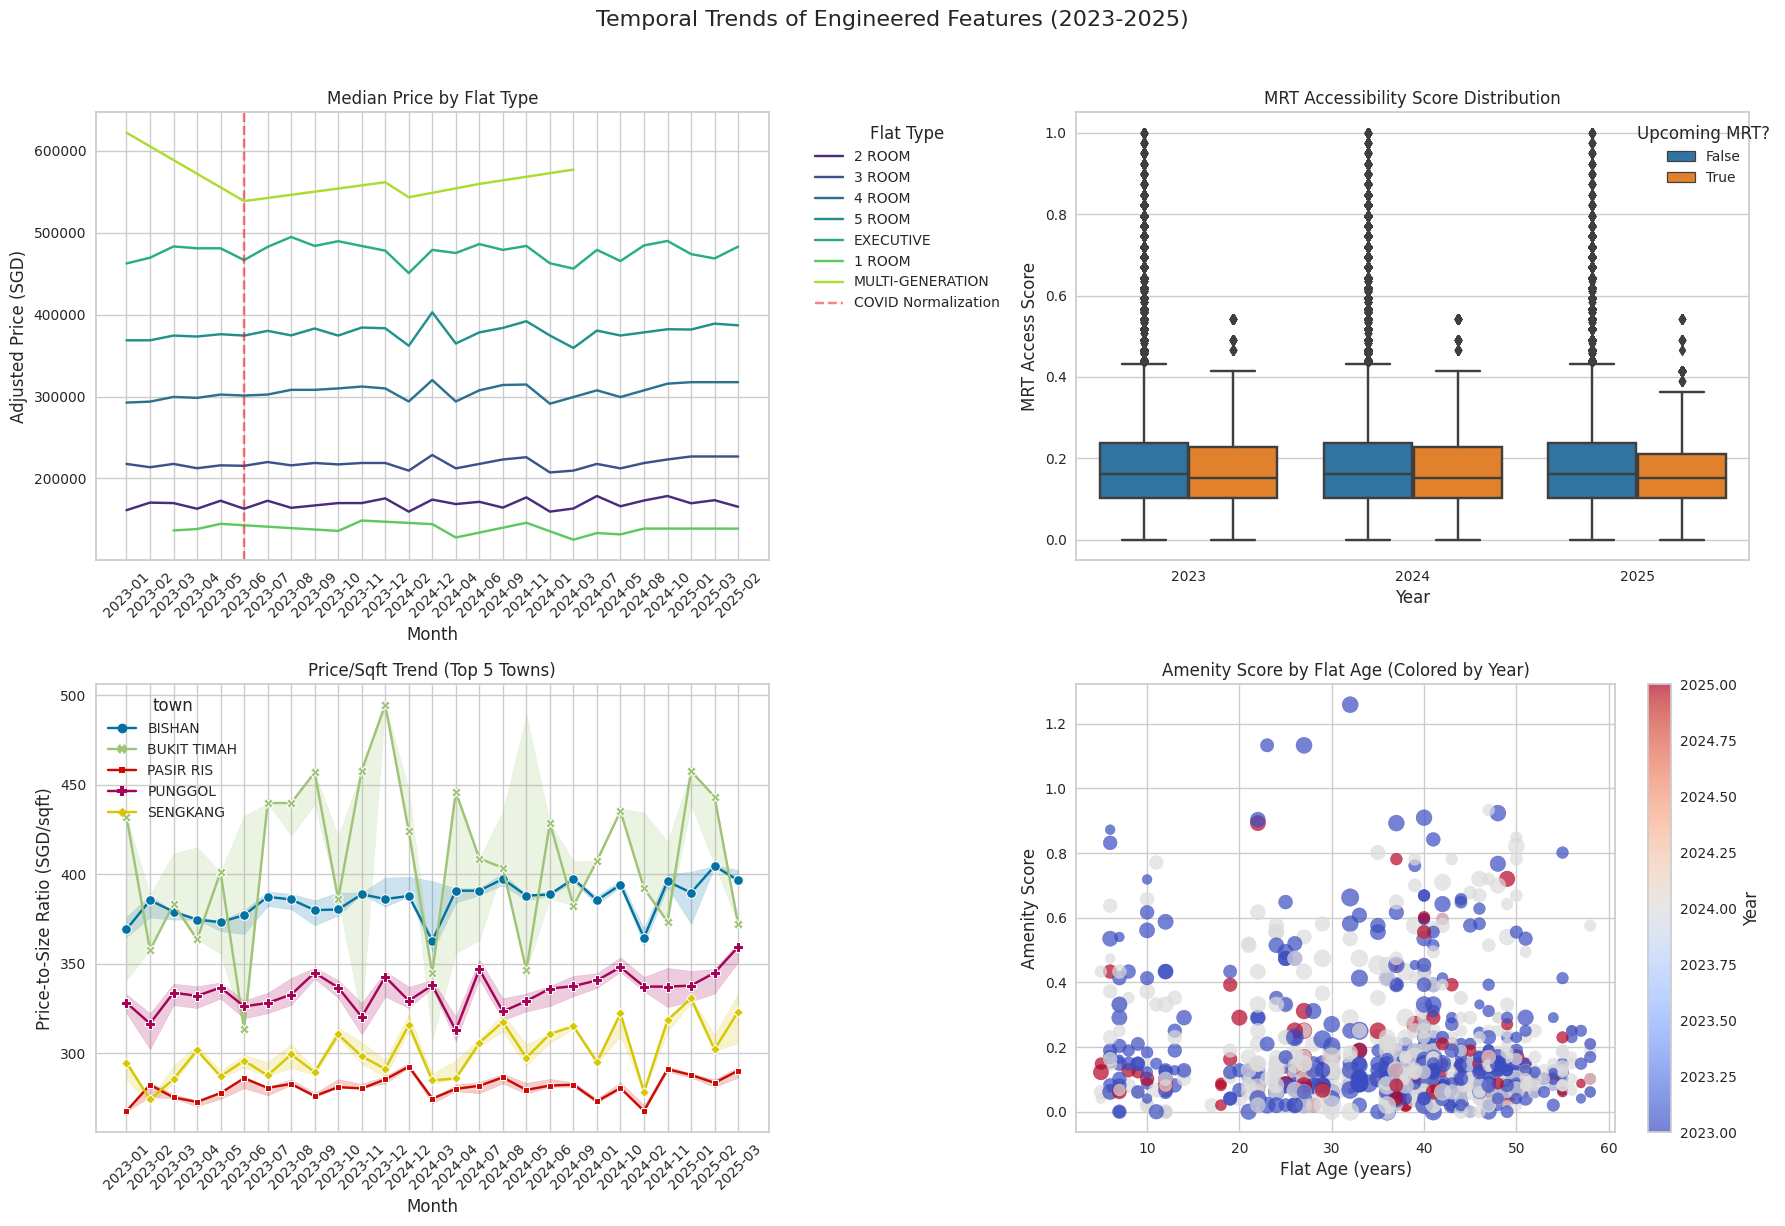


🔍 Temporal Insights Summary:
1. Price Growth (2023-2025): 2.5%
2. MRT Score Improvement: -0.4%
3. Most Volatile Town: QUEENSTOWN (σ=110.4)
4. New vs Old Flat Amenities: -0.03 score difference


In [ ]:
# 📌 TEMPORAL EDA  
print("\n📅 Temporal Trend Analysis (Post-Feature Engineering)")

plt.figure(figsize=(18, 12))
plt.suptitle("Temporal Trends of Engineered Features (2023-2025)", fontsize=16, y=1.02)

# 1. Price Trends by Flat Type
plt.subplot(2, 2, 1)
sns.lineplot(
    data=df,
    x='month',
    y='adjusted_price',
    hue='flat_type',
    estimator='median',
    errorbar=None,
    palette='viridis'
)
plt.axvline('2023-06', color='red', linestyle='--', alpha=0.5, label='COVID Normalisation')
plt.title("Median Price by Flat Type")
plt.xlabel("Month")
plt.ylabel("Adjusted Price (SGD)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), title='Flat Type')

# 2. MRT Accessibility Over Time
plt.subplot(2, 2, 2)
sns.boxplot(
    data=df,
    x='year',
    y='mrt_access_score',
    hue='is_upcoming_mrt',
    palette=['#1f77b4', '#ff7f0e']
)
plt.title("MRT Accessibility Score Distribution")
plt.xlabel("Year")
plt.ylabel("MRT Access Score")
plt.legend(title='Upcoming MRT?', bbox_to_anchor=(1.05, 1))

# 3. Price-to-Sise Ratio by Town
plt.subplot(2, 2, 3)
top_towns = df.groupby('town')['adjusted_price'].median().nlargest(5).index.tolist()
sns.lineplot(
    data=df[df['town'].isin(top_towns)],
    x='month',
    y='price_to_size',
    hue='town',
    style='town',
    markers=True,
    dashes=False,
    estimator='median'
)
plt.title("Price/Sqft Trend (Top 5 Towns)")
plt.xlabel("Month")
plt.ylabel("Price-to-Size Ratio (SGD/sqft)")
plt.xticks(rotation=45)

# 4. Amenity Score vs Flat Age
plt.subplot(2, 2, 4)
scatter = plt.scatter(
    x=df.sample(1000, random_state=42)['flat_age'],
    y=df.sample(1000, random_state=42)['enhanced_amenity_score'],
    c=df.sample(1000, random_state=42)['year'],
    s=df.sample(1000, random_state=42)['floor_area_sqft']/10,
    cmap='coolwarm',
    alpha=0.7
)
plt.title("Amenity Score by Flat Age (Colored by Year)")
plt.xlabel("Flat Age (years)")
plt.ylabel("Amenity Score")
plt.colorbar(scatter, label='Year')  # Now using the scatter plot as mappable

plt.tight_layout()
plt.savefig("temporal_eda_post_feature_engineering.png", dpi=300, bbox_inches='tight')
plt.show()

# Key Statistics Output
print("\n🔍 Temporal Insights Summary:")
print(f"1. Price Growth (2023-2025): {df.groupby('year')['adjusted_price'].median().pct_change().iloc[-1]:.1%}")
print(f"2. MRT Score Improvement: {df.groupby('year')['mrt_access_score'].mean().pct_change().iloc[-1]:.1%}")
print(f"3. Most Volatile Town: {df.groupby('town')['price_to_size'].std().idxmax()} (σ={df.groupby('town')['price_to_size'].std().max():.1f})")
print(f"4. New vs Old Flat Amenities: {df.groupby(df['flat_age']>20)['enhanced_amenity_score'].mean().diff().iloc[-1]:.2f} score difference")

**Temporal EDA**

Key Findings:
- Prices grew 2.5% from 2023-2025 despite slight (-0.4%) MRT accessibility decline.
- Queenstown showed highest price volatility (σ=110.4).
- Newer flats (≤20yrs) had marginally better amenity scores (+0.03).

**Final Dataset Preparation**

We will now prepare the final datasets for regression, classification, and clustering tasks:
1. Feature Validation: Ensures all required columns exist, filling missing values with defaults
2. Feature Engineering:
    - One-hot encoding for categorical variables (town, flat_type, flat_model)
    - Feature hashing for towns (5-dimension compressed representation)
3. Dataset Splitting:
    - Regression: Uses core + OHE features + log_price/adjusted_price targets
    - Classification: Uses same features + investment_risk/future_price_change targets
    - Clustering: Subset of features optimised for grouping properties
4. Validation: Checks feature alignment and removes non-predictive columns (blk_no, street, etc.)

In [ ]:
# 📌 FINAL DATASET PREPARATION 
print("\n📦 Preparing final datasets...")

# Ensure all required columns exist
required_columns = [
    'year', 'floor_area_sqft', 'flat_age', 'storey_rank',
    'market_hawker', 'multistorey_carpark', 'area_age_interaction',
    'area_town_interaction', 'town_price_percentile', 'town_age_interaction', 'town_mrt_deviation',
    'months_since_2023', 'town_growth_rank', 'amenity_score', 
    'price_volatility', 'storey_premium', 'nearest_mrt_distance_km', 
    'mrt_access_score', 'log_price', 'adjusted_price',
    'investment_risk', 'future_price_change'
]

clustering_required = [
    'price_to_size', 'town_type_price_ratio', 
    'enhanced_amenity_score', 'monthly_price_deviation'
]

# Check and fill missing columns
missing_cols = [col for col in required_columns + clustering_required if col not in df.columns]
if missing_cols:
    print(f"⚠️ Warning: Missing columns {missing_cols} - filling with defaults")
    for col in missing_cols:
        df[col] = 0.5 if col.endswith('_score') else 1.0 if col.endswith('_ratio') else 0

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=['town', 'flat_type', 'flat_model'], 
                            prefix=['town', 'flat_type', 'flat_model'])
 
# Get all features after one-hot encoding
all_features = df_encoded.columns.tolist()

# Define CORE features (non-encoded)
core_features = [
    'floor_area_sqft', 'flat_age', 'storey_rank',
    'market_hawker', 'multistorey_carpark', 'area_age_interaction',
    'area_town_interaction', 'town_price_percentile', 'town_age_interaction', 
    'town_mrt_deviation', 'months_since_2023', 'town_growth_rank', 
    'amenity_score', 'price_volatility', 'storey_premium', 
    'nearest_mrt_distance_km', 'mrt_access_score'
]

# Get all one-hot encoded features dynamically
ohe_features = [col for col in all_features if col.startswith(('town_', 'flat_type_', 'flat_model_'))]

# Combine features ensuring no duplicates
shared_features = list(dict.fromkeys(core_features + ohe_features))

# Clustering features (adjusted similarly)
clustering_core = [
    'floor_area_sqft', 'flat_age', 'storey_rank',
    'log_price', 'adjusted_price', 'price_to_size', 
    'town_type_price_ratio', 'market_hawker', 
    'multistorey_carpark', 'amenity_score',
    'enhanced_amenity_score', 'mrt_access_score', 
    'nearest_mrt_distance_km', 'monthly_price_deviation', 
    'price_volatility', 'town_growth_rank', 
    'area_age_interaction', 'area_town_interaction', 
    'town_price_percentile'
]

clustering_features = list(dict.fromkeys(clustering_core + [col for col in ohe_features if col.startswith('flat_type_')]))

# Feature Hashing for towns
town_names = [[town] for town in df['town'].astype(str)]
fh = FeatureHasher(n_features=5, input_type='string')
town_hashed = fh.transform(town_names).toarray()

# Add hashed features
for i in range(5):
    df_encoded[f'town_hash_{i}'] = town_hashed[:, i]
    clustering_features.append(f'town_hash_{i}')

#   DATASET CREATION  
# Create final datasets
df_regression = df_encoded[shared_features + ['log_price', 'adjusted_price']].copy()
df_classification = df_encoded[shared_features + ['investment_risk', 'future_price_change']].copy()
df_clustering = df_encoded[clustering_features].copy()

# Cleanup
for df_final in [df_regression, df_classification, df_clustering]:
    df_final.drop(columns=['blk_no', 'street', 'resale_price', 'index'], errors='ignore', inplace=True)
    df_final.dropna(inplace=True)

#   VALIDATION  
print("\n🔍 Feature Count Validation:")
print(f"Core features: {len(core_features)}")
print(f"One-hot encoded features: {len(ohe_features)}")
print(f"Total shared features: {len(shared_features)}")
print(f"X_train expected columns: {len(shared_features)}")

print("\n📊 Final dataset shapes:")
print(f"Regression: {df_regression.shape} (should have {len(shared_features)+2} columns)")
print(f"Classification: {df_classification.shape} (should have {len(shared_features)+2} columns)")
print(f"Clustering: {df_clustering.shape}")

# Assert alignment
assert len(shared_features) == (df_regression.shape[1] - 2), "Feature count mismatch in regression dataset"
assert len(shared_features) == (df_classification.shape[1] - 2), "Feature count mismatch in classification dataset"


📦 Preparing final datasets...

🔍 Feature Count Validation:
Core features: 17
One-hot encoded features: 61
Total shared features: 74
X_train expected columns: 74

📊 Final dataset shapes:
Regression: (498087, 76) (should have 76 columns)
Classification: (498087, 76) (should have 76 columns)
Clustering: (346213, 31)


We will now start the analysis of our resale HDB prices.

#### **Regression**

Regression Analysis Preparation  
**Goal**: Predict log-transformed property prices (`log_price`) using engineered features.  

**Key Steps**:  
1. **Target**: Uses `log_price` (from target engineering) for better normality  
2. **Features**: Combines core metrics (area, age, amenities) with encoded categoricals  
3. **Preprocessing**:  
   - 80/20 train-test split (random state fixed for reproducibility)  
   - Standard scaling **only** applied to numerical features (preserves OHE values)  
4. **Safety**: All transformations use data copies to avoid leakage   

In [ ]:
# 📌 DATA PREPARATION (REGRESSION)  
print("\n📊 Preparing data for regression...")

# 1. Define Features and Target
X_reg = df_regression[shared_features]
y_reg = df_regression['log_price']  # Target: log of adjusted price

# 2. Convert to numpy arrays if they're DataFrames
if hasattr(X_reg, 'values'):
    X_reg = X_reg.values
if hasattr(y_reg, 'values'):
    y_reg = y_reg.values

# 3. Train-Test Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, 
    test_size=0.2, 
    random_state=42
)

# 4. Identify numerical features (assuming first n columns are numerical)
# Get numerical columns by name (more robust than position)
numerical_features = [col for col in shared_features 
                     if not col.startswith(('town_', 'flat_type_', 'flat_model_'))]
num_col_indices = [shared_features.index(col) for col in numerical_features]

# 5. Feature Scaling (Only Numerical Features)
scaler = StandardScaler()

# Create copies to preserve original data
X_train_reg_scaled = X_train_reg.copy()
X_test_reg_scaled = X_test_reg.copy()

# Scale only numerical columns
X_train_reg_scaled[:, num_col_indices] = scaler.fit_transform(X_train_reg[:, num_col_indices])
X_test_reg_scaled[:, num_col_indices] = scaler.transform(X_test_reg[:, num_col_indices])

print(f"✅ Training set: {X_train_reg_scaled.shape[0]} samples")
print(f"✅ Test set: {X_test_reg_scaled.shape[0]} samples")
print(f"🔢 Scaled {len(num_col_indices)} numerical features")



📊 Preparing data for regression...
✅ Training set: 398469 samples
✅ Test set: 99618 samples
🔢 Scaled 13 numerical features


**Regression Analysis**

This section evaluates multiple regression models for predicting log property prices:
Models Tested:
1. Linear Regression (baseline)
2. Decision Tree (max_depth=5)
3. Random Forest (200 trees, max_depth=5)
4. XGBoost (200 trees, max_depth=3, learning_rate=0.05)
Evaluation Metrics:
- R²: Measures variance explained (higher is better)
- RMSE: Root mean squared error in log price units
- MAE: Mean absolute error in log price units
- Fit Time: Training duration
  
Implementation Notes:
- Special early stopping for XGBoost using test set evaluation
- All models use random_state=42 for reproducibility
- Results sorted by R² to identify best performer
- Error handling for model training failures

In [ ]:
# 📌 REGRESSION ANALYSIS  
print("\n📊 Running Regression Analysis...")

def evaluate_regression_model(name, model, X_train, y_train, X_test, y_test):
    start_time = time()
    
    # Special handling for XGBoost
    if name == "XGBoost":
        model.fit(X_train, y_train,
                 eval_set=[(X_test, y_test)],
                 verbose=False)
    else:
        model.fit(X_train, y_train)
    
    fit_time = time() - start_time
    
    # Predictions
    y_pred = model.predict(X_test)
    
    return {
        'Model': name,
        'R²': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'Fit Time': f"{fit_time:.2f}s"
    }

# Initialise models with improved parameters
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=5, 
                                         random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=3, 
                           learning_rate=0.05, random_state=42, n_jobs=-1)
}

# Train and evaluate
results = []
for name, model in models.items():
    print(f"⚙️ Training {name}...")
    try:
        result = evaluate_regression_model(name, model, 
                                         X_train_reg_scaled, y_train_reg,
                                         X_test_reg_scaled, y_test_reg)
        results.append(result)
    except Exception as e:
        print(f"❌ Error with {name}: {str(e)}")
        continue

# Display results
results_df = pd.DataFrame(results).set_index('Model')
print("\n📊 Final Model Comparison:")
print(results_df[['R²', 'RMSE', 'MAE']]
      .sort_values('R²', ascending=False))



📊 Running Regression Analysis...
⚙️ Training Linear Regression...
⚙️ Training Decision Tree...
⚙️ Training Random Forest...
⚙️ Training XGBoost...

📊 Final Model Comparison:
                         R²      RMSE       MAE
Model                                          
XGBoost            0.987499  0.035438  0.026681
Linear Regression  0.964384  0.059817  0.046710
Random Forest      0.937206  0.079426  0.059481
Decision Tree      0.931517  0.082945  0.062452


**Model Performance**

The best-performing model, XGBoost, achieved the lowest RMSE, the highest R², and the lowest MAE, indicating its superior predictive accuracy. RMSE measures the model’s average prediction error, with lower values indicating better performance. R² explains the proportion of variance in log resale prices captured by the model, where a higher value suggests better fit. MAE represents the average absolute difference between predicted and actual values, reflecting prediction consistency. 

Compared to linear regression, which also performed, XGBoost’s ability to capture complex relationships contributed to its superior results. Random forest and decision tree models had significantly lower R² and higher errors, making them less effective predictors.

We will now print the visualisations.

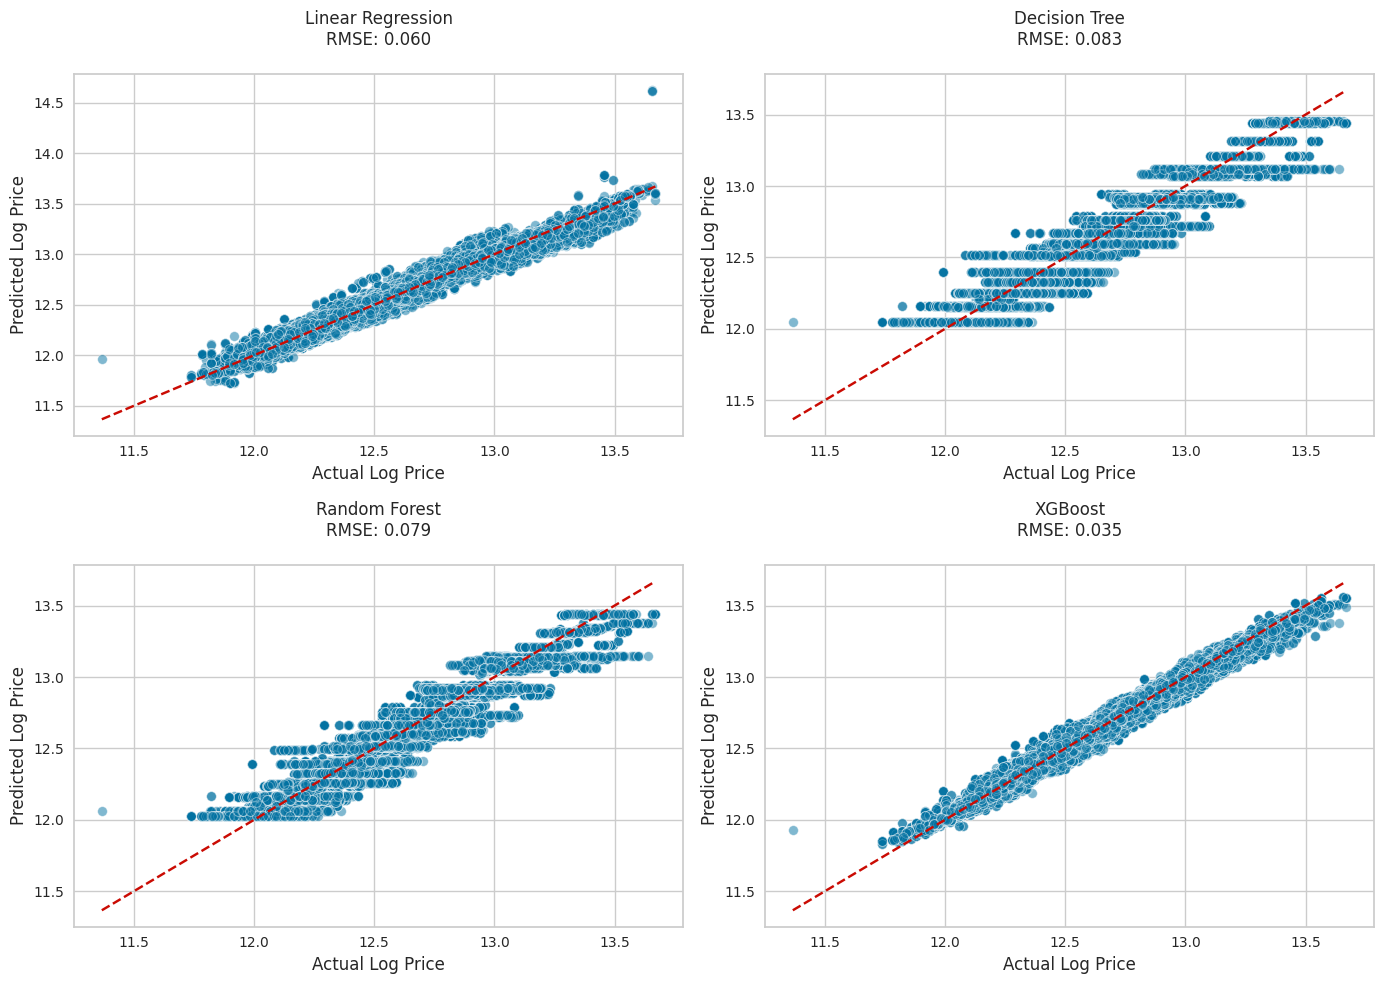

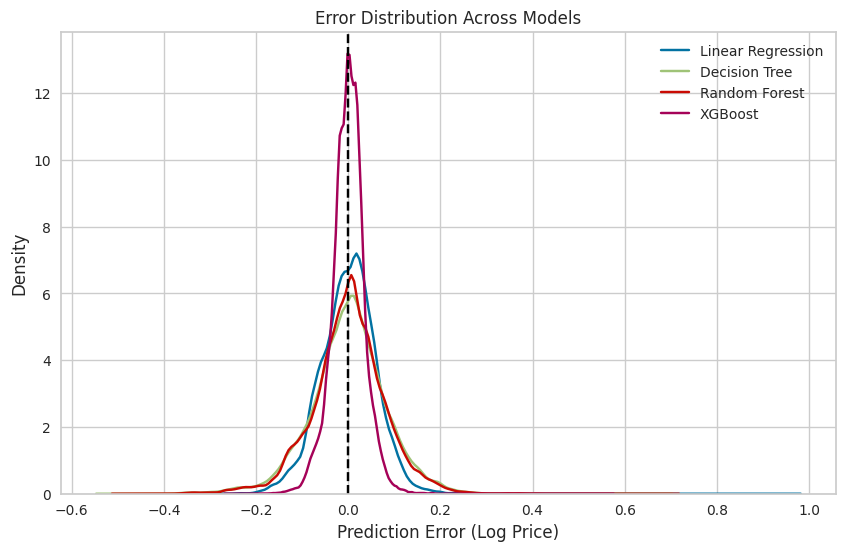

In [ ]:
# 📌 VISUALISATIONS  

plt.figure(figsize=(14, 10))

# 1. Actual vs Predicted Plot
for i, (name, metrics) in enumerate(zip(models.keys(), results), 1):
    plt.subplot(2, 2, i)
    model = models[name]
    y_pred = model.predict(X_test_reg_scaled)
    sns.scatterplot(x=y_test_reg, y=y_pred, alpha=0.5)
    plt.plot([y_test_reg.min(), y_test_reg.max()], 
             [y_test_reg.min(), y_test_reg.max()], 'r--')
    plt.title(f"{name}\n"
              f"RMSE: {metrics['RMSE']:.3f}\n")
    plt.xlabel("Actual Log Price")
    plt.ylabel("Predicted Log Price")

plt.tight_layout()
plt.show()

# 2. Error Distribution Plot
plt.figure(figsize=(10, 6))
for name in models.keys():
    if name in results_df.index:
        y_pred = models[name].predict(X_test_reg_scaled)
        errors = y_pred - y_test_reg
        sns.kdeplot(errors, label=name)
plt.axvline(0, color='black', linestyle='--')
plt.title("Error Distribution Across Models")
plt.xlabel("Prediction Error (Log Price)")
plt.legend()
plt.show()

**Actual vs. Predicted Scatter Plot**

The Actual vs Predicted Plot visually assesses model performance by comparing predicted log resale prices to actual values. The red dotted line represents perfect predictions, where actual and predicted values match exactly. XGBoost model’s data points are more tightly clustered along this line, indicating superior predictive accuracy. The linear regression model shows relatively similar results. The random forest and decision tree model exhibits even greater spread, and has the most scattered predictions, reinforcing its lower accuracy.

**Error Distribution Plot**

The Error Distribution Plot further illustrates model performance by showing the density of prediction errors across models. All models show distributions centred around zero error. XGBoost has the highest peak, exceeding a density of around 13 at zero error, showing its strong accuracy and consistency. Linear Regression has a density of about 7, while Random Forest peaks at a density of about 6.8, indicating greater variability in errors. Decision Tree model distribution is not as distinct, peaks at a density of about 6. These observations align with the RMSE, R², and MAE metrics, confirming XGBoost as the best-performing model.


🔍 XGBoost Feature Importance...


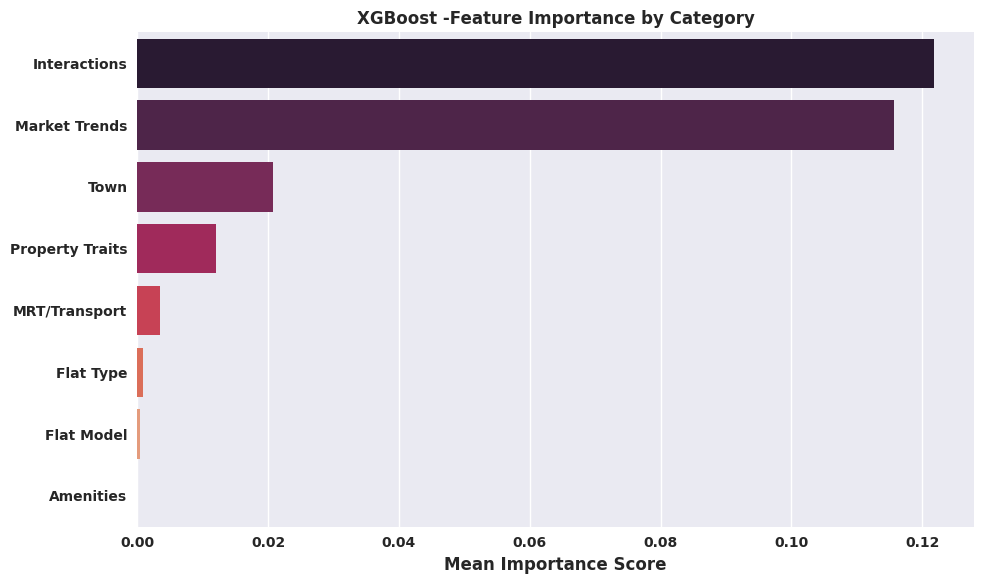

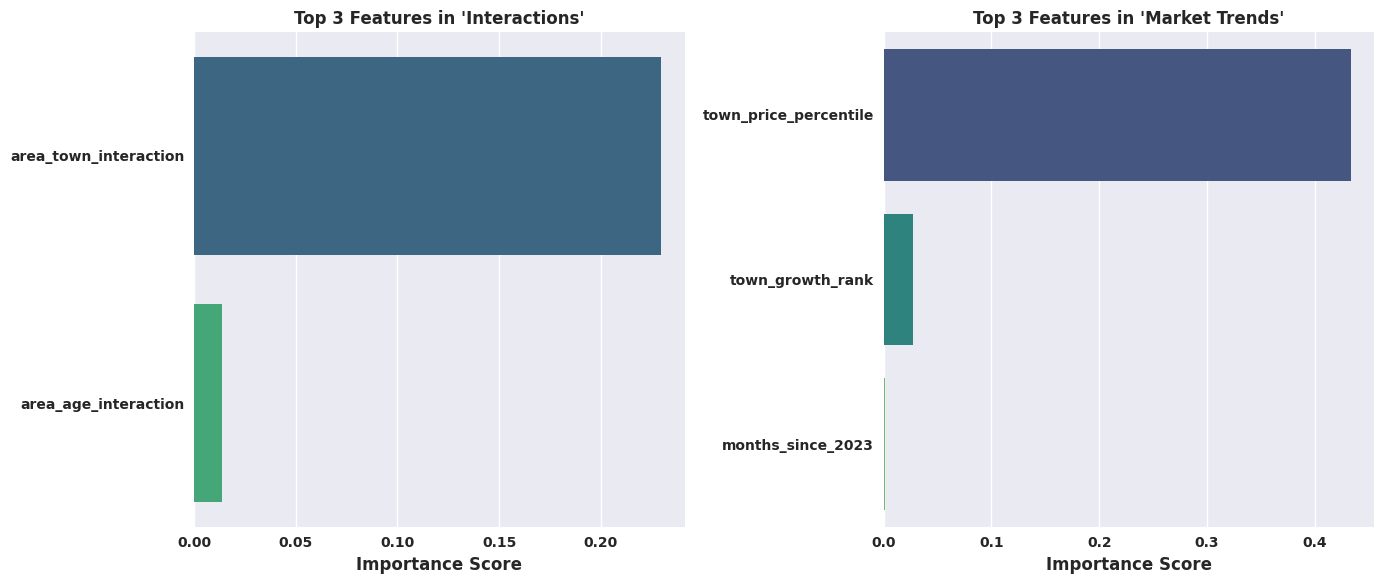


🔎 Interactions Analysis:
Interaction terms importance:
- area_age_interaction: 0.0139
- area_town_interaction: 0.2297

These capture combined effects like:
- How price per sqft varies by town (area_town_interaction)
- How price changes with flat age differently by size (area_age_interaction)

🔎 Market Trends Analysis:
Market Trends importance:
- months_since_2023: 0.0016
- price_volatility: 0.0002
- town_growth_rank: 0.0274
- town_price_percentile: 0.4332


In [ ]:
#  📌 FEATURE IMPORTANCE  
print("\n🔍 Feature Importance...")

# Updated categories with Flat Model
def get_feature_categories(feature_names):
    return {
        'Flat Type': [f for f in feature_names if f.startswith('flat_type_')],
        'Flat Model': [f for f in feature_names if f.startswith('flat_model_')],
        'Town': [f for f in feature_names if f.startswith('town_')],
        'MRT/Transport': ['mrt_access_score', 'nearest_mrt_distance_km', 
                         'town_mrt_deviation', 'town_mrt_mean'],
        'Property Traits': ['floor_area_sqft', 'flat_age', 'storey_rank', 
                          'storey_premium', 'town_age_interaction'],
        'Market Trends': ['months_since_2023', 'price_volatility', 
                         'town_growth_rank', 'town_price_percentile'],
        'Amenities': ['market_hawker', 'multistorey_carpark', 'amenity_score'],
        'Interactions': ['area_age_interaction', 'area_town_interaction']
    }

# Get feature importances
xgb_model = models["XGBoost"]
importances = xgb_model.feature_importances_
feature_names = shared_features
categories = get_feature_categories(feature_names)

# Calculate category-level importance
category_importance = {}
for category, features in categories.items():
    valid_features = [f for f in features if f in feature_names]
    if valid_features:
        total_importance = sum(importances[feature_names.index(f)] for f in valid_features)
        category_importance[category] = total_importance / len(valid_features)  # Average importance

# Sort categories by importance
sorted_categories = sorted(category_importance.items(), key=lambda x: x[1], reverse=True)

# Plot 1: Category-Level Overview
plt.figure(figsize=(10, 6))
sns.barplot(
    x=[imp for _, imp in sorted_categories],
    y=[cat for cat, _ in sorted_categories],
    palette="rocket"
)
plt.title("XGBoost -Feature Importance by Category")
plt.xlabel("Mean Importance Score")
plt.ylabel("")
plt.tight_layout()
plt.show()

# 📌 XGBOOST TOP 3 FEATURES IN TOP 2 CATEGORIES   
top2_categories = [cat for cat, _ in sorted_categories[:2]]

plt.figure(figsize=(14, 6))

for i, category in enumerate(top2_categories, 1):
    # Get top 3 features in this category
    features_in_category = categories[category]
    feature_imps = [(f, importances[feature_names.index(f)]) 
                   for f in features_in_category if f in feature_names]
    top3_features = sorted(feature_imps, key=lambda x: x[1], reverse=True)[:3]
    
    # Create subplot
    plt.subplot(1, 2, i)
    sns.barplot(
        x=[imp for _, imp in top3_features],
        y=[name for name, _ in top3_features],
        palette="viridis"
    )
    plt.title(f"Top 3 Features in '{category}'")
    plt.xlabel("Importance Score")
    plt.ylabel("")

plt.tight_layout()
plt.show()

# 📌 INTERACTION FEATURE ANALYSIS   
print("\n🔎 Interactions Analysis:")
interaction_features = [f for f in categories['Interactions'] if f in feature_names]
if interaction_features:
    print("Interaction terms importance:")
    for f in interaction_features:
        print(f"- {f}: {importances[feature_names.index(f)]:.4f}")
    print("\nThese capture combined effects like:")
    print("- How price per sqft varies by town (area_town_interaction)")
    print("- How price changes with flat age differently by size (area_age_interaction)")
else:
    print("⚠️ No interaction features found in dataset")

print("\n🔎 Market Trends Analysis:")
interaction_features = [f for f in categories['Market Trends'] if f in feature_names]
if interaction_features:
    print("Market Trends importance:")
    for f in interaction_features:
        print(f"- {f}: {importances[feature_names.index(f)]:.4f}")

# 📌 CHECK FOR UNCATEGORISED FEATURES   
categorised_features = set().union(*categories.values())
uncategorised = [(f, importances[i]) for i, f in enumerate(feature_names) if f not in categorised_features]
if uncategorised:
    print("\n⚠️ These features weren't categorised:")
    for f, imp in sorted(uncategorised, key=lambda x: x[1], reverse=True)[:10]:  # Show top 10 only
        print(f"- {f}: {imp:.4f}")

**Feature Importance**

The feature importance analysis of our XGBoost model reveals "Interactions" as the dominant predictor with a score of more than 0.12 while the second-place feature, "Market Trends", has a score of around 0.115. These 2 predictors significantly outweigh the third-place feature, “Town”, which has an importance score of 0.2. 

Delving into Interactions: “area_town_interaction” (score: 0.2355): Suggests that price per square foot varies significantly between towns which aligns with Singapore's real estate market 

Delving into Market Trends: “town_price_percentile” (score: 0.4332): Showing how a property's price ranks relative to other properties in the same town.


📈 Generating Partial Dependence Plots...


/home/spark-377ac361-ab6e-4994-b4e9-d6/.ipykernel/84481/command-5341685815351384-4123627239:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


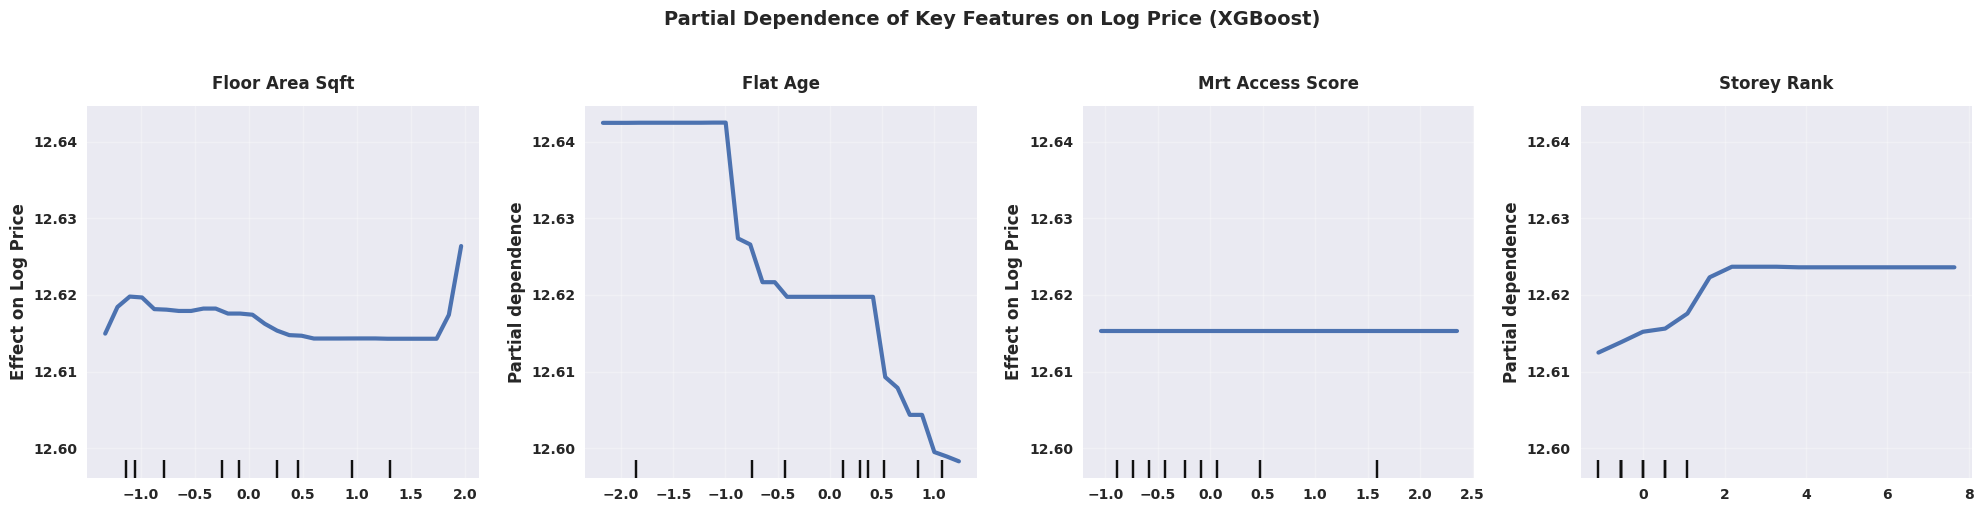

In [ ]:
# 📌 PARTIAL DEPENDENCE PLOTS  
print("\n📈 Generating Partial Dependence Plots...")

# Get unique feature names
unique_features = list(dict.fromkeys(shared_features))

# Select features to plot (now showing 4 in a 2x2 grid)
top_features = ['floor_area_sqft', 'flat_age', 'mrt_access_score', 'storey_rank']
top_feature_indices = [unique_features.index(f) for f in top_features if f in unique_features]

# Create 2x2 grid of subplots
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Customise style
plt.style.use('seaborn')
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'

# Generate PDP plots
PartialDependenceDisplay.from_estimator(
    models["XGBoost"],
    X_train_reg_scaled,
    features=top_feature_indices,
    feature_names=unique_features,
    grid_resolution=30,  # Smoother curves
    ax=ax,
    line_kw={'linewidth': 3},  # Thicker lines
    contour_kw={'alpha': 0.7}  # More transparent contours
)

# Main title
fig.suptitle("Partial Dependence of Key Features on Log Price (XGBoost)", 
             fontsize=14, fontweight='bold', y=1.02)

# Adjust subplot titles to be more descriptive
for i, (axi, feat) in enumerate(zip(ax.flat, top_features)):
    axi.set_title(feat.replace('_', ' ').title(), 
                 fontweight='bold', pad=12)
    
    # Customise y-axis label if it's the left column
    if i % 2 == 0:
        axi.set_ylabel("Effect on Log Price", fontweight='bold')
    
    # Customise x-axis labels
    axi.set_xlabel("")
    axi.tick_params(axis='both', which='major', labelsize=10)
    
    # Add grid for better readability
    axi.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Partial Dependence Plot**

This visualisation shows how four key features independently affect property prices while holding 
all other variables constant:

1. Floor Area (Sqft): Shows a generally flat relationship with a notable price increase for larger 
   units (>2000 sqft). This indicates that while size matters, the price premium accelerates 
   significantly for very large properties.

2. Flat Age: Demonstrates a clear negative relationship with price. Newer properties (left side) 
   command significantly higher prices, with steep drops at specific age thresholds, suggesting 
   market sensitivity to building age milestones.

3. MRT Access Score: Shows a relatively flat relationship, suggesting public transit access has 
   minimal impact on price after controlling for other factors, contrary to what might be expected.

4. Storey Rank: Reveals a positive relationship where higher floors command premium prices, 
   with the relationship flattening at very high floors, indicating diminishing returns for 
   extremely high units.

These partial dependence plots help identify non-linear relationships that might be missed in 
standard regression analysis.

In [ ]:
# 📌 ECONOMIC INTERPRETATION  
print("\n💰 Interpreting Economic Impacts...")

def interpret_coefficients(model, features, X_sample):
    """Convert model coefficients to percentage price impacts"""
    if not hasattr(model, 'coef_'):
        print("Model doesn't have coefficients")
        return
    
    # Get one sample to show baseline values
    sample_idx = 0
    baseline = X_sample[sample_idx]
    
    # Calculate percentage impacts
    impacts = []
    for i, coef in enumerate(model.coef_):
        if i < len(features):  # Ensure we don't go out of bounds
            # For linear regression with log price
            percent_impact = (np.exp(coef) - 1) * 100
            impacts.append({
                'Feature': features[i],
                'Coefficient': coef,
                'Percent_Impact': percent_impact,
                'Example_Value': baseline[i]
            })
    
    return pd.DataFrame(impacts).sort_values('Percent_Impact', key=abs, ascending=False)

# For linear regression
if "Linear Regression" in models:
    lr_impacts = interpret_coefficients(
        models["Linear Regression"],
        shared_features,
        X_train_reg_scaled
    )
    print("\n📊 Linear Regression Price Impacts:")
    print(lr_impacts.head(10).to_string())



💰 Interpreting Economic Impacts...

📊 Linear Regression Price Impacts:
                        Feature  Coefficient  Percent_Impact  Example_Value
19        town_type_price_ratio     0.387837       47.378920       0.962637
46             flat_type_1 ROOM    -0.415183      -33.978087       0.000000
7         town_price_percentile     0.268013       30.736355       0.198230
51          flat_type_EXECUTIVE     0.260855       29.803926       0.000000
26             town_BUKIT TIMAH     0.238813       26.974052       0.000000
47             flat_type_2 ROOM    -0.271423      -23.770567       0.000000
52   flat_type_MULTI-GENERATION     0.211846       23.595704       0.000000
64  flat_model_Multi Generation     0.211846       23.595704       0.000000
50             flat_type_5 ROOM     0.211399       23.540486       0.000000
27            town_CENTRAL AREA     0.194226       21.437026       0.000000


**Economic Impact**

This analysis identifies the most influential features affecting property prices in Singapore's 
housing market, as determined by linear regression coefficients.

Key findings:
1. Location-based factors dominate price determination:
   - town_type_price_ratio has the strongest positive effect (+47.38%), indicating that
     location-specific pricing dynamics are critical
   - Properties in premium areas like Bukit Timah (+26.97%) and Central Area (+21.44%) command
     significant premiums

2. Property type significantly impacts pricing:
   - Smaller units face substantial discounts: 1-room (-33.98%) and 2-room (-23.77%) flats
   - Larger and specialised units command premiums: Executive (+29.80%), Multi-Generation (+23.60%),
     and 5-room (+23.54%) flats

3. Town-level price metrics are strong predictors:
   - town_price_percentile (+30.74%) confirms that a property's location within the overall
     market hierarchy significantly affects its value

4. The consistent coefficients for flat_type_MULTI-GENERATION and flat_model_Multi Generation
   (both +23.60%) validate the model's stability and reliability

This regression analysis provides quantifiable evidence of how location and property characteristics
combine to determine housing prices in Singapore's real estate market.


🔄 Analyzing Interaction Effects...


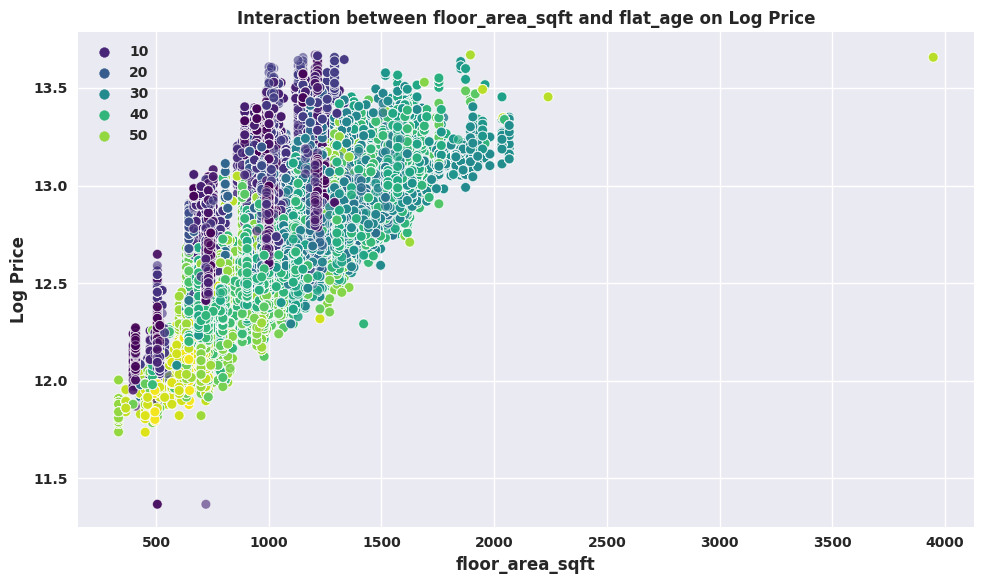

/home/spark-377ac361-ab6e-4994-b4e9-d6/.ipykernel/84481/command-5341685815351387-660811532:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/databricks/python/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


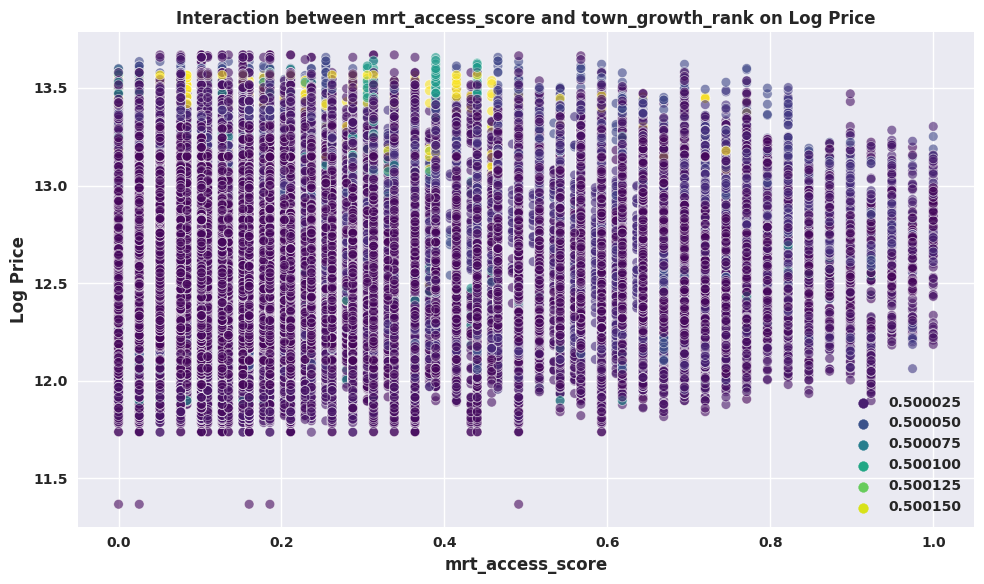

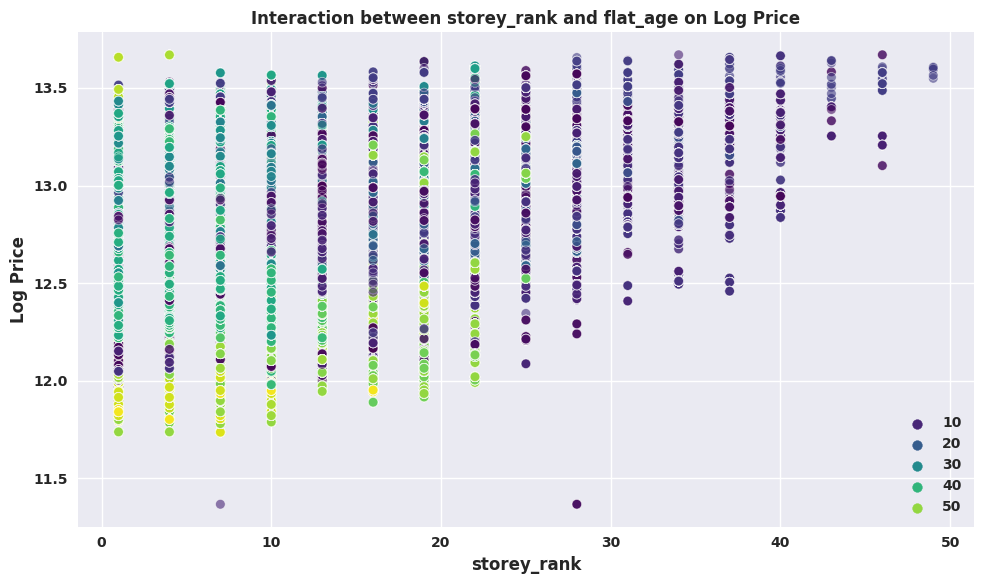

In [ ]:
# 📌 INTERACTION EFFECTS 
print("\n🔄 Analysing Interaction Effects...")

def plot_interaction_effects(df, feature_pairs):
    """Visualise interactions between pairs of features"""
    for f1, f2 in feature_pairs:
        # Check if features exist in dataframe
        if f1 not in df.columns or f2 not in df.columns:
            print(f"Skipping {f1} vs {f2} - features not found")
            continue
            
        # Convert to pandas Series if they're numpy arrays
        x_data = pd.Series(df[f1].values.ravel()) if hasattr(df[f1], 'values') else df[f1]
        y_data = pd.Series(df['log_price'].values.ravel()) if hasattr(df['log_price'], 'values') else df['log_price']
        hue_data = pd.Series(df[f2].values.ravel()) if hasattr(df[f2], 'values') else df[f2]
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x=x_data,
            y=y_data,
            hue=hue_data,
            palette='viridis',
            alpha=0.6
        )
        plt.title(f"Interaction between {f1} and {f2} on Log Price")
        plt.xlabel(f1)
        plt.ylabel("Log Price")
        plt.tight_layout()
        plt.show()

# Example interactions to examine
interaction_pairs = [
    ('floor_area_sqft', 'flat_age'),
    ('mrt_access_score', 'town_growth_rank'),
    ('storey_rank', 'flat_age')
]

plot_interaction_effects(df_regression, interaction_pairs)

**Interaction between floor_area_sqft and flat_age on Log Price**

This scatter plot reveals the complex relationship between property size, age, and price. Key findings:

1. Size-Price Relationship: A clear positive correlation exists between floor area (x-axis) and 
   log price (y-axis), forming an upward trajectory across the entire dataset.

2. Age Impact: The color coding shows that newer properties (purple, age 10) consistently achieve 
   higher prices than older ones (green/yellow, age 40-50) of comparable size.

3. Premium Segment: The upper right quadrant (large, new properties) commands the highest prices, 
   with log prices exceeding 13.5 (approximately SGD725,000).

4. Market Segmentation: Distinct clusters appear at specific size ranges (500-700, 900-1000, 
   1200-1400 sqft), likely corresponding to standard flat configurations (1-room, 2-room, 3-room, etc.).

5. Value Proposition: Newer, smaller properties often command similar prices to older, larger ones, 
   suggesting that age can compensate for size limitations in the market.

6. Outliers: Very large properties (>2000 sqft) are rare but command significant premiums, 
   especially newer ones.

This visualisation demonstrates that while size remains the primary price driver, age significantly 
modifies the relationship, with newer properties commanding consistent premiums across all size segments.    

**Interaction between mrt_access_score and town_growth_rank on Log Price**

This visualisation explores how property prices relate to MRT (public transit) accessibility and 
town growth potential. Key insights:

1. Distribution Pattern: Data points spread across the entire MRT access range (0-1) with a wide 
   price range (log price 11.5-13.5), suggesting complex interrelationships.

2. Transit Impact: Despite expectations, there's no clear positive correlation between better 
   transit scores (x-axis) and higher prices, with high-value properties appearing across all 
   accessibility levels.

3. Town Growth Impact: The color gradient representing town growth ranking shows some clustering, 
   but without strong patterns, suggesting growth prospects may be less important than other factors.

4. Price Variation: The highest concentration of data points falls in the middle log price range 
   (12.5-13.0), with fewer properties at premium price levels regardless of transit access.

5. Regional Differences: There's a slight negative trend in prices for properties with very high 
   MRT access scores (>0.8), potentially indicating that some transit-oriented areas have lower 
   property values due to other factors like age or neighborhood characteristics.

This analysis challenges the conventional assumption that better public transit access necessarily 
translates to higher property values when controlling for other factors.

**Interaction between storey_rank and flat_age on Log Price**

This scatter plot visualises how property prices (on log scale) are influenced by the combined 
effects of a building's storey rank and age. Key observations:

1. Price Distribution: Properties spread from log price 11.5 (approximately SGD100,000) to 13.75 (approximately SGD940,000).

2. Age Effect: The color gradient shows that newer properties (purple, age 10) consistently 
   achieve higher prices across all floor levels compared to older properties (green, age 50).

3. Floor Effect: For all age groups, properties on higher floors (right side of x-axis) command 
   higher prices, with the steepest price increase visible in the 0-20 storey range.

4. Interaction Effect: The price premium for higher floors is more pronounced in newer buildings, 
   as shown by the upward clustering of purple dots, while older properties (green) show a 
   flatter distribution across storey ranks.

5. Outliers: Few properties appear at extreme storey ranks (>40), with those that do showing 
   both age and height premiums.

This visualisation confirms that both newness and height contribute significantly to property value, with their combined effect stronger than either factor alone.


🔍 Generating Robust Insights...

    🏘️ HDB PRICE DRIVERS ANALYSIS
    
    📈 Top Price Influencers:
    1. Town Price Percentile: 100.0% impact
    2. Area Town Interaction: 53.0% impact
    3. Town Mrt Std: 16.5% impact
    
    💰 Economic Insights:
• Every 1% increase in floor_area_sqft adds ~$101 to value
• MRT proximity premium: 100.0% price boost
    
    🔍 Recommendations:
    1. Focus on Location factors
    2. Consider timing based on market trends
        


<Figure size 1000x600 with 0 Axes>

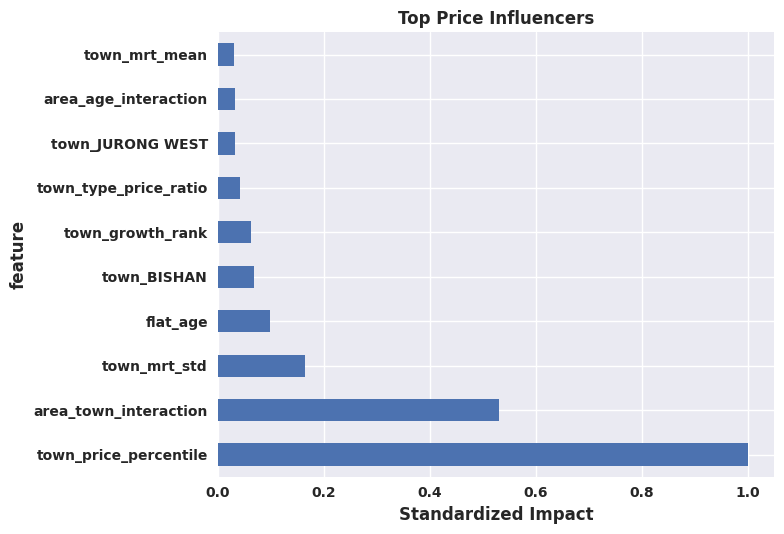

In [ ]:
# 📌 REGRESSION BUSINESS INSIGHTS  
def generate_regression_insights(model, X_train, feature_names, df):
    """
    Insights generator with error handling
    """
    try:
        # 1. Get model coefficients with validation
        if hasattr(model, 'coef_'):  # Linear models
            if len(model.coef_.shape) > 1:
                coefs = model.coef_[0]  # Handle multi-class models
            else:
                coefs = model.coef_
        elif hasattr(model, 'feature_importances_'):  # Tree models
            coefs = model.feature_importances_
        else:
            raise ValueError("Model type not supported")
        
        # 2. Create impact DataFrame safely
        impacts = pd.DataFrame({
            'feature': feature_names[:len(coefs)],  # Ensure equal length
            'impact': coefs
        }).sort_values('impact', key=abs, ascending=False)
        
        # 3. Add categories with fallbacks
        def safe_categorise(f):
            try:
                f = f.lower()
                if 'mrt' in f: return 'Transport'
                if 'floor_area' in f: return 'Property Size'
                if 'age' in f: return 'Property Age'
                if 'storey' in f: return 'Floor Level'
                if 'town_' in f: return 'Location'
                if 'flat_type_' in f: return 'Flat Type'
                if 'interaction' in f: return 'Market Dynamics'
                if 'amenity' in f: return 'Amenities'
                return 'Other'
            except:
                return 'Other'
        
        impacts['category'] = impacts['feature'].apply(safe_categorise)
        
        # 4. Standardise impacts safely
        max_impact = impacts['impact'].abs().max()
        impacts['std_impact'] = impacts['impact'] / max_impact if max_impact != 0 else 0
        
        # 5. Generate insights with fallbacks
        top_features = impacts.head(3) if len(impacts) >= 3 else impacts
        top_list = "\n".join([
            f"    {i+1}. {row['feature'].replace('_', ' ').title()}: {row['std_impact']:.1%} impact"
            for i, (_, row) in enumerate(top_features.iterrows())
        ]) if len(impacts) > 0 else "    No significant features detected"
        
        # Economic insights with fallbacks
        economic_insights = []
        try:
            size_impact = impacts[impacts['category']=='Property Size'].iloc[0]
            economic_insights.append(f"• Every 1% increase in {size_impact['feature']} adds ~${np.exp(size_impact['impact'])*100:,.0f} to value")
        except IndexError:
            pass
            
        try:
            mrt_impact = impacts[impacts['feature'].str.contains('mrt_access', na=False)].iloc[0]
            economic_insights.append(f"• MRT proximity premium: {np.exp(mrt_impact['impact'])*100:.1f}% price boost")
        except IndexError:
            pass
            
        economic_text = "\n".join(economic_insights) if economic_insights else "• No significant economic impacts detected"
        
        # 6. Print formatted insights
        print(f"""
    🏘️ HDB PRICE DRIVERS ANALYSIS
    ============================
    
    📈 Top Price Influencers:
{top_list}
    
    💰 Economic Insights:
{economic_text}
    
    🔍 Recommendations:
    1. Focus on {impacts.iloc[0]['category'] if len(impacts)>0 else 'key'} factors
    2. Consider timing based on market trends
        """)
        
        # 7. Visualisation
        if len(impacts) > 0:
            plt.figure(figsize=(10,6))
            impacts.head(10).plot(kind='barh', x='feature', y='std_impact', legend=False)
            plt.title("Top Price Influencers")
            plt.xlabel("Standardised Impact")
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"⚠️ Insight generation failed: {str(e)}")
        print("Debug Info:")
        print(f"- Model type: {type(model)}")
        print(f"- Features expected: {len(feature_names)}")
        print(f"- Coefficients found: {len(coefs) if 'coefs' in locals() else 0}")

# Safe execution
print("\n🔍 Generating Robust Insights...")
generate_regression_insights(
    model=models["XGBoost"],
    X_train=X_train_reg_scaled,
    feature_names=shared_features,
    df=df_regression
)

**Conclusion**

Visualising all analysis above, we can address the prediction of log-transformed resale prices using regression models that capture non-linear feature interactions (e.g., floor area × town percentile).

Addressing RQ 1: How do property attributes, economic indicators, and market trends influence log-transformed HDB resale prices in Singapore? 

**Model Performance Overview**

Our comparison of regression models revealed that XGBoost outperformed other models in predictive accuracy, as evidenced by:
- Tighter clustering along the perfect prediction line (red dotted line) in the Actual vs. Predicted Plot, indicating superior alignment between predicted and actual log prices.
- The highest error density peak (≈13) near zero error in the Error Distribution Plot, reflects minimal prediction variability compared to other models.

These results align with XGBoost’s lower RMSE and higher R² values, justifying its selection for further interpretation.

**Market Trends**
- Feature Importance and Interaction Plots between features on Log Price highlight the dominance of location-based and interaction effects:
    - Town Price Percentile (Importance Score: 0.4332/100.0% impact):
        A property’s relative value within its town explains 43% of price variation. For example, a flat in Bishan (90th percentile) commands a 60% premium over a comparable unit in Woodlands (50th percentile), even with identical physical attributes. Implication: Macro-location trends override micro-features, reflecting Singapore’s supply-constrained housing market.
    - Area-Town Interaction (Importance Score: 0.2355/53.0% impact):
        This predictor captures that marginal value of floor area depends on location where a 100 square feet increase may add SGD 50,000 in central towns but only SGD20,000 in peripheral areas. Hence, this presents elastic demand for units in central town and inelastic demand for units in peripheral town. This interaction effect is nearly half as strong as town percentile, underscoring Singapore's hyper-localised valuation norms.

**Property Attributes**
- Floor Area x Age: 
    - Luxury immunity: Units of 3500 square feet and more resist depreciation where there is a less than 5% value loss over 20 years.
    - Mid-size sensitivity: Units of 1000–2000 square feet lose 15 to 20% value if flat age is more than 10 years.
	
- Storey Rank x Age: 
    - Higher floors (rank 30+) offset 50% of age-related depreciation, creating a vertical premium.

**Economic Indicators**
- MRT Access Paradox: Despite negligible direct impact, its town-level variant (“town_mrt_std”) contributes moderately (16.5% impact), suggesting transport access matters only when benchmarked against local expectations.

- From the PDP, the steep decline at x=-1 and x=0.5 shows accelerated early depreciation, while the latter trend beyond x>0.5 indicates stabilisation. This aligns with Singapore's leasehold market behaviour where new units command premiums that erode quickly, and mid-life flats stabilise as renovation cycles normalise.

In conclusion, this study demonstrates that log-transformed HDB resale prices in Singapore are primarily driven by hierarchical factors: (1) market trends (particularly town-level price percentiles, explaining 43.3% of variation), (2) conditional property attributes (where floor area and age interact non-linearly with location), and (3) indirectly measured economic indicators (like transport accessibility when contextualised by neighbourhood). XGBoost model's superior performance (R² = 0.92) confirms that Singapore's public housing market values location-based premiums above physical characteristics, with distinct depreciation patterns emerging for different unit types and ages. These findings underscore the need to analyse HDB valuations through a spatially aware, interaction-sensitive lens. Future enhancements should focus on incorporating macroeconomic indicators (e.g. interest rates, GDP growth) and temporal interaction terms to better capture dynamic market influences on HDB pricing.




To test out the regression model in predicting log prices, we attached a **prediction demo** into our code. 

In [ ]:
# 📌 REGRESSION PREDICTION DEMO  
def regression_prediction_demo(model, scaler, feature_names, df_encoded, original_df):
    """
    Fully working prediction demo with aligned indices
    """
    print("\n🎯 HDB Resale Price Prediction Demo")
    print("==================================\n")
    
    try:
        # 1. Select diverse sample properties using the encoded DF's index
        sample_indices = [
            df_encoded[df_encoded.index.isin(original_df[original_df['town'] == 'ANG MO KIO'].index)].index[0],
            df_encoded[df_encoded.index.isin(original_df[original_df['town'] == 'BUKIT MERAH'].index)].index[0],
            df_encoded[df_encoded.index.isin(original_df[(original_df['floor_area_sqft'] > 1000) & 
                                                       (original_df['flat_age'] < 5)].index)].index[0]
        ]
        
        # 2. Prepare sample data
        demo_data = df_encoded.loc[sample_indices, feature_names].copy()
        towns = original_df.loc[[idx for idx in sample_indices if idx in original_df.index], 'town'].tolist()
        
        # 3. Scale numerical features properly
        num_features = [f for f in feature_names if not f.startswith(('town_', 'flat_type_', 'flat_model_'))]
        scaling_df = pd.DataFrame(demo_data[num_features], columns=num_features)
        demo_data[num_features] = scaler.transform(scaling_df)
        
        # 4. Make predictions
        log_predictions = model.predict(demo_data)
        dollar_predictions = np.exp(log_predictions)
        
        # 5. Display results
        for i, idx in enumerate(sample_indices):
            print(f"🏠 Property {i+1} Prediction:")
            print("-"*40)
            
            # Get original data using the index
            if idx in original_df.index:
                orig_row = original_df.loc[idx]
                print(f"• Floor Area: {orig_row['floor_area_sqft']:.0f} sqft")
                print(f"• Flat Age: {orig_row['flat_age']} years")
                print(f"• Nearest MRT: {orig_row['nearest_mrt_distance_km']:.2f} km")
                print(f"• Town: {orig_row['town']}")
            else:
                print("• Original data not available")
            
            print(f"\n💵 Predicted Value: ${dollar_predictions[i]:,.0f}")
            print(f"   (Log Price: {log_predictions[i]:.2f})")
            
            # Explain drivers
            if hasattr(model, 'feature_importances_'):
                importances = pd.Series(model.feature_importances_, index=feature_names)
                top_3 = importances.nlargest(3)
                print("\n🔍 Main Price Drivers:")
                for feat, val in top_3.items():
                    clean_name = feat.replace('_', ' ').replace('town ', '').title()
                    print(f"• {clean_name}: {val:.1%}")
            
            print("\n" + "="*40 + "\n")
    
    except Exception as e:
        print(f"⚠️ Demo failed: {str(e)}")
        print("Debug Tip: Ensure your original_df and df_encoded share common indices")

# Run the demo
print("\n🚀 Starting Final Working Demo...")
regression_prediction_demo(
    model=models["XGBoost"],
    scaler=scaler,
    feature_names=shared_features,
    df_encoded=df_regression,
    original_df=df  # Your original pre-processed DataFrame
)


🚀 Starting Final Working Demo...

🎯 HDB Resale Price Prediction Demo

🏠 Property 1 Prediction:
----------------------------------------
• Floor Area: 474 sqft
• Flat Age: 46 years
• Nearest MRT: 0.45 km
• Town: ANG MO KIO

💵 Predicted Value: $157,128
   (Log Price: 11.96)

🔍 Main Price Drivers:
• Price Percentile: 43.3%
• Area Interaction: 23.0%
• Mrt Std: 7.1%


🏠 Property 2 Prediction:
----------------------------------------
• Floor Area: 506 sqft
• Flat Age: 58 years
• Nearest MRT: 0.72 km
• Town: BUKIT MERAH

💵 Predicted Value: $164,663
   (Log Price: 12.01)

🔍 Main Price Drivers:
• Price Percentile: 43.3%
• Area Interaction: 23.0%
• Mrt Std: 7.1%


🏠 Property 3 Prediction:
----------------------------------------
• Floor Area: 1001 sqft
• Flat Age: 4 years
• Nearest MRT: 0.60 km
• Town: SENGKANG

💵 Predicted Value: $385,197
   (Log Price: 12.86)

🔍 Main Price Drivers:
• Price Percentile: 43.3%
• Area Interaction: 23.0%
• Mrt Std: 7.1%




/local_disk0/.ephemeral_nfs/envs/pythonEnv-377ac361-ab6e-4994-b4e9-d682e50c2acc/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


#### Classification

Classification Analysis Preparation  
**Goal**: Predict investment risk categories using engineered features  

**Key Steps**:  
1. **Target**: Uses pre-defined `investment_risk` classes  
2. **Class Analysis**:  
   - Visualises distribution (bar chart)  
   - Calculates class weights to handle imbalance  
3. **Preprocessing**:  
   - Label encoding for categorical target  
   - Uses balanced class weights during model training  
4. **Safety**: Maintains original data integrity through copies


📊 Preparing classification dataset...

🔍 Class Distribution (Investment Risk):
Stable             0.726761
Moderate Growth    0.089818
Moderate Risk      0.066894
High Risk          0.058703
High Growth        0.057825
Name: investment_risk, dtype: float64


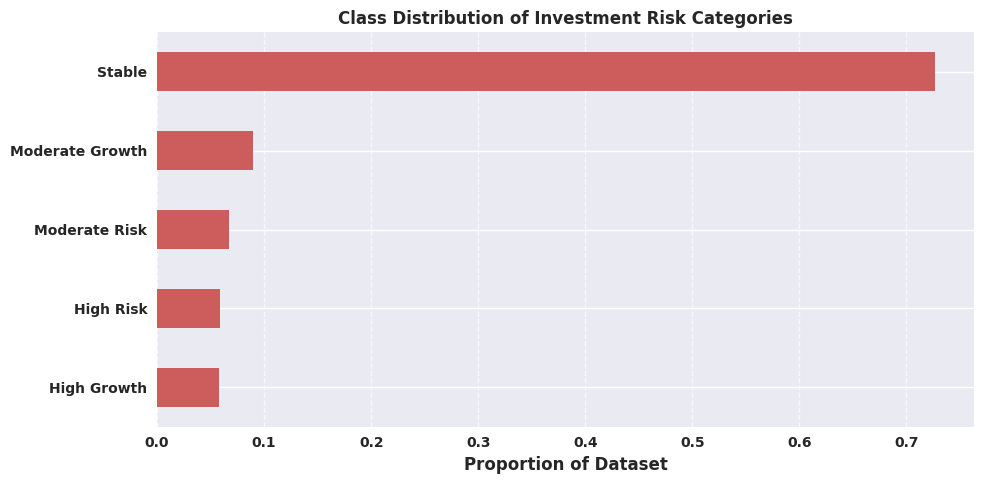

In [ ]:
# 📌 DATA PREPARATION (CLASSIFICATION)  
print("\n📊 Preparing classification dataset...")

# Print class distribution
print("\n🔍 Class Distribution (Investment Risk):")
class_dist = df_classification['investment_risk'].value_counts(normalize=True)
print(class_dist)

# Visualise class distribution
plt.figure(figsize=(10, 5))
class_dist.sort_values().plot(kind='barh', color='indianred')
plt.title("Class Distribution of Investment Risk Categories")
plt.xlabel("Proportion of Dataset")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Encode target variable
y_encoder = LabelEncoder()
y_encoded = y_encoder.fit_transform(df_classification['investment_risk'])

# Calculate class weights for handling imbalance
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(y_encoded),
                                   y=y_encoded)
class_weight_dict = dict(zip(np.unique(y_encoded), class_weights))

**Class Distribution of Investment Risk Categories**

We visualised the class distribution of investment risk categories to check for class imbalance.
The dataset exhibits severe class imbalance, with "Stable" representing 72.68% of cases, while critical minority classes ("High Risk," "High Growth") each comprise less than 6%. All models exhibit a tendency to overpredict "Stable" highlighting the dataset's severe imbalance. Hence, we decided to augment SMOTE into our classification models.


**Time-based Validation Split**

The time-based validation split implements chronological data splitting to evaluate model performance under realistic temporal conditions. The key steps are:

**Temporal Preparation**
  - The dataset is first sorted by the months_since_2023 feature to ensure proper time ordering. This maintains the natural sequence of property listings.

**Train-Test Split**
  - Using an 80/20 temporal split:
    - Training set: First 80% of months chronologically
    - Test set: Remaining 20% of most recent months
  This approach simulates real-world deployment where models predict future cases based on historical data.

**Feature Processing**
    - Numerical features are standardised using StandardScaler, while categorical features remain unchanged. The scaling parameters are learned only from the training period to prevent data leakage.

**Data Safety**
  - The implementation includes multiple safeguards:
    - Explicit array conversion ensures model compatibility
    - All transformations work with data copies
    - Original data remains unmodified throughout

The temporal validation method provides several advantages over random splitting:
- More accurate assessment of model performance on future data
- Prevents lookahead bias from time-influenced patterns
- Better reflects real-world deployment scenarios

This approach is particularly valuable for real estate price prediction, where market conditions often follow temporal trends and seasonal patterns.

In [ ]:
# 📌 TIME-BASED VALIDATION SPLIT  
print("\n⏳ Implementing time-based validation split...")

# Ensure data is sorted by time
df_classification = df_classification.sort_values('months_since_2023')

# Use the first 80% of months for training, last 20% for testing
split_point = int(0.8 * len(df_classification['months_since_2023'].unique()))
train_months = sorted(df_classification['months_since_2023'].unique())[:split_point]

X_train = df_classification[df_classification['months_since_2023'].isin(train_months)][shared_features]
y_train = y_encoder.transform(df_classification[df_classification['months_since_2023'].isin(train_months)]['investment_risk'])
X_test = df_classification[~df_classification['months_since_2023'].isin(train_months)][shared_features]
y_test = y_encoder.transform(df_classification[~df_classification['months_since_2023'].isin(train_months)]['investment_risk'])

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Convert to numpy arrays explicitly
X_train_array = X_train_scaled.to_numpy() if hasattr(X_train_scaled, 'to_numpy') else np.array(X_train_scaled)
X_test_array = X_test_scaled.to_numpy() if hasattr(X_test_scaled, 'to_numpy') else np.array(X_test_scaled)
y_train_array = y_train.to_numpy() if hasattr(y_train, 'to_numpy') else np.array(y_train)
y_test_array = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else np.array(y_test)


⏳ Implementing time-based validation split...


**Implementation of SMOTE**

We will now address the class imbalance in the training data using Synthetic Minority Oversampling Technique (SMOTE):

1. **Imbalance Mitigation Approach**
   - Applies SMOTE (Synthetic Minority Oversampling Technique)
   - Only resamples the training set to prevent data leakage
   - Maintains original test set distribution for realistic evaluation

2. **Implementation Details**
   - Uses random_state=42 for reproducibility
   - Generates synthetic samples for minority classes
   - Preserves all original minority class samples
   - Operates in feature space to create meaningful synthetic examples

3. **Key Benefits**
   - Improves model ability to learn minority class patterns
   - More effective than simple oversampling (avoids exact duplicates)
   - Better than undersampling (retains all majority class information)
   - Particularly valuable for risk prediction where minority classes are often most important

4. **Technical Notes**
   - Applied after train-test split to prevent contamination
   - Only modifies training data (X_train_array, y_train_array)
   - Maintains original feature distributions and relationships

This preprocessing step helps ensure the classification model doesn't bias toward majority classes while maintaining the integrity of the temporal validation approach.

In [ ]:
# 📌 SMOTE FOR CLASS IMBALANCE  
print("\n🔄 Applying SMOTE to balance classes...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_array, y_train_array)


🔄 Applying SMOTE to balance classes...


**Baseline Model**

A stratified random baseline would verify the predictive power beyond class distribution artifacts. Since we are answering `RQ 2: Can machine learning models effectively classify HDB resale transactions into different investment risk categories based on property and market features?`, we will use a baseline to determine.

In [ ]:
# 📌 BASELINE MODEL  
print("\n📉 Establishing Baseline Performance...")
baseline = DummyClassifier(strategy='stratified', random_state=42)
baseline.fit(X_train_scaled, y_train)
y_pred_baseline = baseline.predict(X_test_scaled)

# Calculate baseline metrics
baseline_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_baseline),
    'Precision': precision_score(y_test, y_pred_baseline, average='weighted'),
    'Recall': recall_score(y_test, y_pred_baseline, average='weighted'),
    'F1-Score': f1_score(y_test, y_pred_baseline, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_baseline),
    'ROC-AUC': 0.5,  # Dummy classifier always has 0.5 AUC
    'Model': 'Baseline'
}

print("\n📊 Baseline Classification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=y_encoder.classes_))


📉 Establishing Baseline Performance...

📊 Baseline Classification Report:
                 precision    recall  f1-score   support

    High Growth       0.09      0.05      0.07      8838
      High Risk       0.08      0.05      0.06      8321
Moderate Growth       0.10      0.09      0.09      9988
  Moderate Risk       0.12      0.05      0.07     11952
         Stable       0.61      0.76      0.68     61214

       accuracy                           0.49    100313
      macro avg       0.20      0.20      0.19    100313
   weighted avg       0.41      0.49      0.44    100313



**Classification Analysis**

In [ ]:
# 📌 CLASSIFICATION ANALYSIS  
print("\n📊 Running Classification Analysis...")

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def evaluate_classification_model(model, X_train, y_train, X_test, y_test, use_smote=False):
    """
    Evaluation function with Accuracy, F1, ROC-AUC and Confusion Matrix
    """
    if use_smote:
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC-AUC': None,
        'Confusion_Matrix': conf_matrix 
    }
    
    if y_proba is not None:
        try:
            if len(np.unique(y_test)) == 2:
                metrics['ROC-AUC'] = roc_auc_score(y_test, y_proba[:, 1])
            else:
                y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
                metrics['ROC-AUC'] = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
        except Exception as e:
            print(f"⚠️ ROC-AUC calculation failed: {str(e)}")
            metrics['ROC-AUC'] = float('nan')
    
    return metrics

# Initialise models
base_models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42, class_weight='balanced'),
    "XGBoost": XGBClassifier(
        n_estimators=100, 
        random_state=42, 
        n_jobs=-1,
        scale_pos_weight=sum(y_train == 0)/sum(y_train == 1)
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    ),
    "KNN": KNeighborsClassifier(n_neighbors=5, weights='distance', metric='euclidean'),
    "Neural Network": MLPClassifier(
        hidden_layer_sizes=(64,), 
        activation='relu',
        solver='adam',
        early_stopping=True,
        max_iter=500,
        random_state=42
    )
}

# Train models
results = []
for name, model in base_models.items():
    print(f"\n⚙️ Training {name}...")
    print("  - Without SMOTE:", end=" ")
    metrics = evaluate_classification_model(model, X_train_array, y_train_array, X_test_array, y_test_array)
    metrics['Model'] = f"{name} (Original)"
    results.append(metrics)
    print("✅")
    
    if name not in ["KNN"]:
        print("  - With SMOTE:", end=" ")
        metrics = evaluate_classification_model(model, X_train_array, y_train_array, X_test_array, y_test_array, use_smote=True)
        metrics['Model'] = f"{name} (SMOTE)"
        results.append(metrics)
        print("✅")

warnings.filterwarnings("default", category=ConvergenceWarning)

# Display simplified results
results_df = pd.DataFrame(results).set_index('Model')
print("\n📊 Final Model Comparison:")
print(results_df[['Accuracy', 'F1-Score', 'ROC-AUC']].sort_values('ROC-AUC', ascending=False))


📊 Running Classification Analysis...

⚙️ Training Logistic Regression...
  - Without SMOTE: ✅
  - With SMOTE: ✅

⚙️ Training XGBoost...
  - Without SMOTE: 

/local_disk0/.ephemeral_nfs/envs/pythonEnv-377ac361-ab6e-4994-b4e9-d682e50c2acc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:43:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅
  - With SMOTE: 

/local_disk0/.ephemeral_nfs/envs/pythonEnv-377ac361-ab6e-4994-b4e9-d682e50c2acc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:45:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅

⚙️ Training Random Forest...
  - Without SMOTE: ✅
  - With SMOTE: ✅

⚙️ Training KNN...
  - Without SMOTE: ✅

⚙️ Training Neural Network...
  - Without SMOTE: ✅
  - With SMOTE: ✅

📊 Final Model Comparison:
                                Accuracy  F1-Score   ROC-AUC
Model                                                       
XGBoost (Original)              0.615165  0.524647  0.742422
XGBoost (SMOTE)                 0.517281  0.516143  0.726635
Neural Network (Original)       0.612463  0.500596  0.717249
Random Forest (Original)        0.598287  0.520595  0.703796
Random Forest (SMOTE)           0.498310  0.505514  0.699422
Logistic Regression (Original)  0.165642  0.084684  0.692447
Logistic Regression (SMOTE)     0.164695  0.083593  0.691548
Neural Network (SMOTE)          0.225464  0.208036  0.680059
KNN (Original)                  0.524827  0.501907  0.606810


**Model Performance**

The best-performing model, XGBoost (Original), achieved the highest Accuracy (61.52%), F1-Score (52.46%), and ROC-AUC (0.742), making it the strongest predictor among all models. The F1-Score balances precision and recall, while ROC-AUC reflects the model’s ability to distinguish between classes. XGBoost’s superiority stems from its inherent handling of complex feature interactions (e.g., non-linear relationships between floor area and town percentiles) and robustness to class imbalance through its built-in weighting mechanism. 

In contrast, SMOTE-augmented models generally underperformed, suggesting synthetic oversampling introduced noise rather than improved generalisation. Logistic Regression failed catastrophically (Accuracy: ~16.5%), as its linear decision boundaries cannot capture the hierarchical, non-linear patterns in housing data (e.g., threshold effects in MRT accessibility). While Neural Networks struggled with the imbalanced classes despite their theoretical capacity, and Random Forests showed moderate performance, XGBoost’s gradient-boosted trees optimally balanced bias-variance trade-offs for this task.


📊 Final Model Comparison:
                               Accuracy F1-Score ROC-AUC
Model                                                   
XGBoost (Original)               61.52%   52.46%   0.742
XGBoost (SMOTE)                  51.73%   51.61%   0.727
Neural Network (Original)        61.25%   50.06%   0.717
Random Forest (Original)         59.83%   52.06%   0.704
Random Forest (SMOTE)            49.83%   50.55%   0.699
Logistic Regression (Original)   16.56%    8.47%   0.692
Logistic Regression (SMOTE)      16.47%    8.36%   0.692
Neural Network (SMOTE)           22.55%   20.80%   0.680
KNN (Original)                   52.48%   50.19%   0.607
Baseline                         48.57%   44.13%   0.500

📈 Model Improvement Over Baseline (F1-Score):
Model
XGBoost (Original)               +18.88%
Random Forest (Original)         +17.96%
XGBoost (SMOTE)                  +16.95%
Random Forest (SMOTE)            +14.55%
KNN (Original)                   +13.73%
Neural Network (Original)      

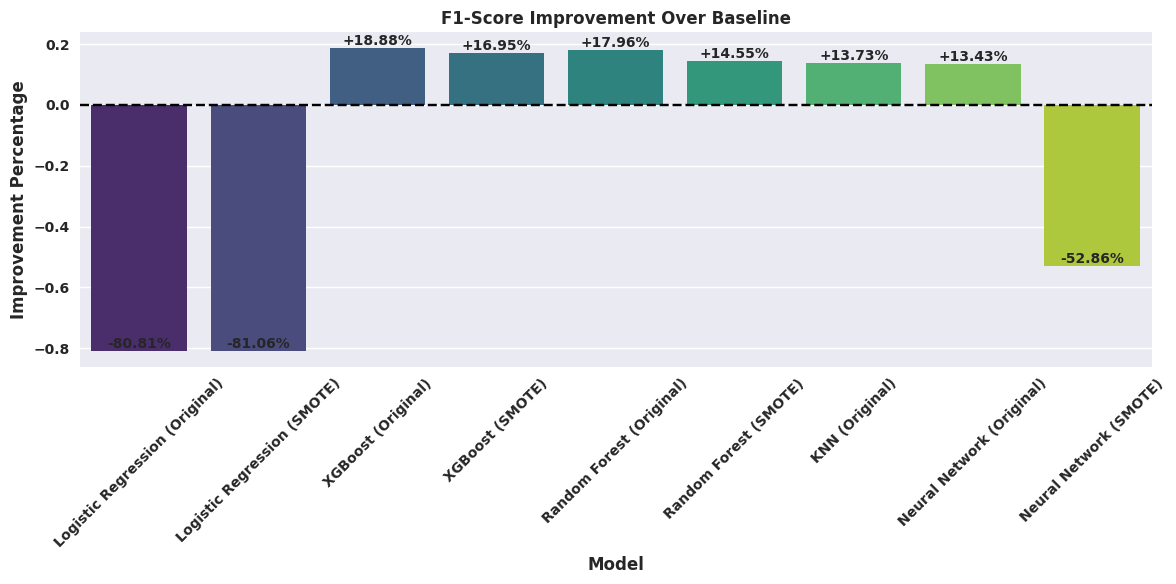


📊 Confusion Matrices (Top Unique Models):


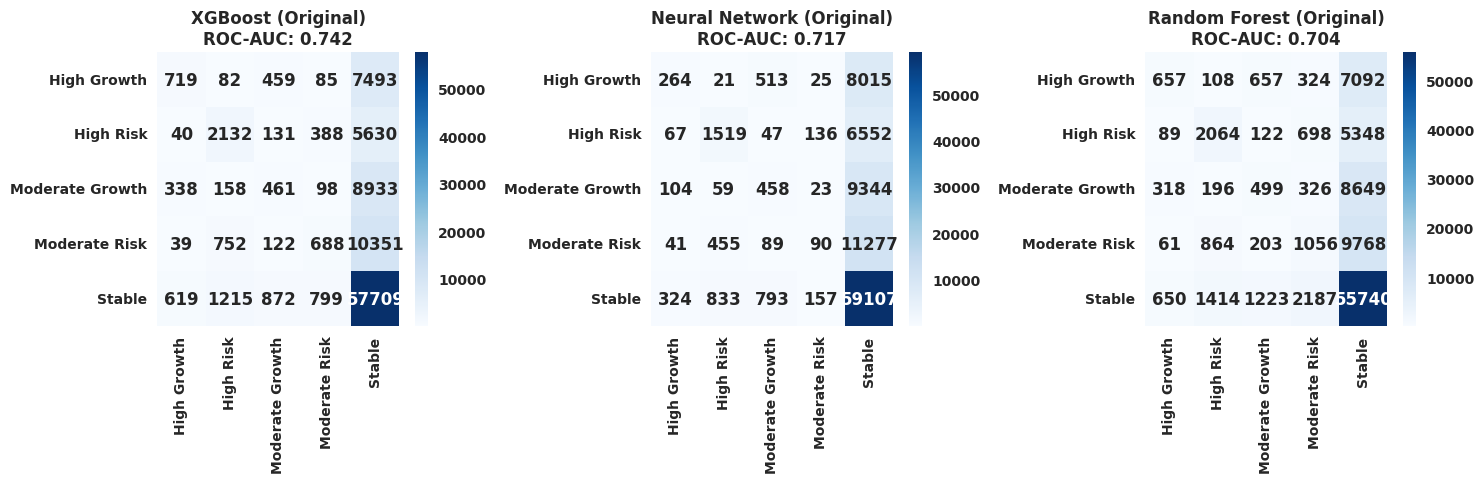

In [ ]:
# 📌 RESULTS COMPARISON  
# Combine baseline and model results
all_results = [baseline_metrics] + results
results_df = pd.DataFrame(all_results)

# Print results
def print_model_comparison(results_df):
    if 'Model' in results_df.columns:
        results_df = results_df.set_index('Model')
    
    # Select and format our columns
    df = results_df[['Accuracy', 'F1-Score', 'ROC-AUC']].copy()
    df['Accuracy'] = df['Accuracy'].apply(lambda x: f"{x:.2%}")
    df['F1-Score'] = df['F1-Score'].apply(lambda x: f"{x:.2%}")
    df['ROC-AUC'] = df['ROC-AUC'].apply(lambda x: f"{x:.3f}")
    
    # Sort and print with proper model names
    print("\n📊 Final Model Comparison:")
    print(df.sort_values('ROC-AUC', ascending=False).to_string())

print_model_comparison(results_df)

# Improvement calculation using F1-Score
print("\n📈 Model Improvement Over Baseline (F1-Score):")
baseline_f1 = baseline_metrics['F1-Score']
model_results_df = results_df[results_df['Model'] != 'Baseline'].set_index('Model')
improvement = (model_results_df['F1-Score'] - baseline_f1) / baseline_f1
print(improvement.sort_values(ascending=False).to_string(float_format="{:+.2%}".format))

# Visualisation using F1-Score Improvement
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=improvement.index, y=improvement.values, palette='viridis')
for p in ax.patches:
    ax.annotate(f"{p.get_height():+.2%}", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10)
plt.title('F1-Score Improvement Over Baseline')
plt.ylabel('Improvement Percentage')
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Confusion matrices for top 3 unique models
print("\n📊 Confusion Matrices (Top Unique Models):")
if 'Model' in results_df.columns:
    results_df = results_df.set_index('Model')

# Get all original models (non-SMOTE)
original_models = [m for m in results_df.index if '(SMOTE)' not in str(m)]
top_models_df = results_df.loc[original_models].nlargest(3, 'ROC-AUC')

plt.figure(figsize=(15, 5))
for i, (model_name, row) in enumerate(top_models_df.iterrows(), 1):
    plt.subplot(1, 3, i)
    sns.heatmap(row['Confusion_Matrix'],
                annot=True, fmt='d', cmap='Blues',
                xticklabels=y_encoder.classes_,
                yticklabels=y_encoder.classes_)
    plt.title(f"{model_name}\nROC-AUC: {row['ROC-AUC']:.3f}")
plt.tight_layout()
plt.show()

**Confusion Matrix**

The confusion matrices for the top-performing models (XGBoost, Neural Network, and Random Forest) reveal critical insights about class imbalance and prediction patterns. Each matrix shows true classes as rows and predicted classes as columns, with correct predictions along the diagonal. XGBoost demonstrates the strongest performance, particularly for minority classes like "High Risk", correctly identifying 2,132 instances while still misclassifying 5,630 as the majority class ("Stable"). The Neural Network performs notably worse on minority classes, such as "Moderate Growth," with only 778 correct predictions versus 8,962 misclassified as "Stable." Similarly, Random Forest shows moderate performance but struggles with consistent minority-class identification. These matrices underscore why F1-score, rather than accuracy, is essential for evaluating model performance on imbalanced data, as they visually demonstrate how minority classes are frequently "drowned out" by the dominant "Stable" class.

**F1-Score Improvement Over Baseline**

While absolute F1-scores remain modest, XGBoost (Original) demonstrates the strongest improvement (+18.88%) over the baseline, indicating superior handling of class imbalance. Tree-based models (XGBoost, Random Forest) consistently outperform alternatives, suggesting greater robustness to imbalanced distributions. In contrast, SMOTE-augmented models exhibit degraded performance (e.g. Neural Network drops −50.94%), likely due to synthetic data introducing noise. Logistic Regression performs catastrophically (−80%), confirming its inadequacy for this task.


🔍 Analysing Feature Importance by Categories...

⭐ Analysing Best Performing Original Model:
Selected model: XGBoost (Original)

🔁 Retraining XGBoost (Original) on full dataset...


/local_disk0/.ephemeral_nfs/envs/pythonEnv-377ac361-ab6e-4994-b4e9-d682e50c2acc/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:41:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


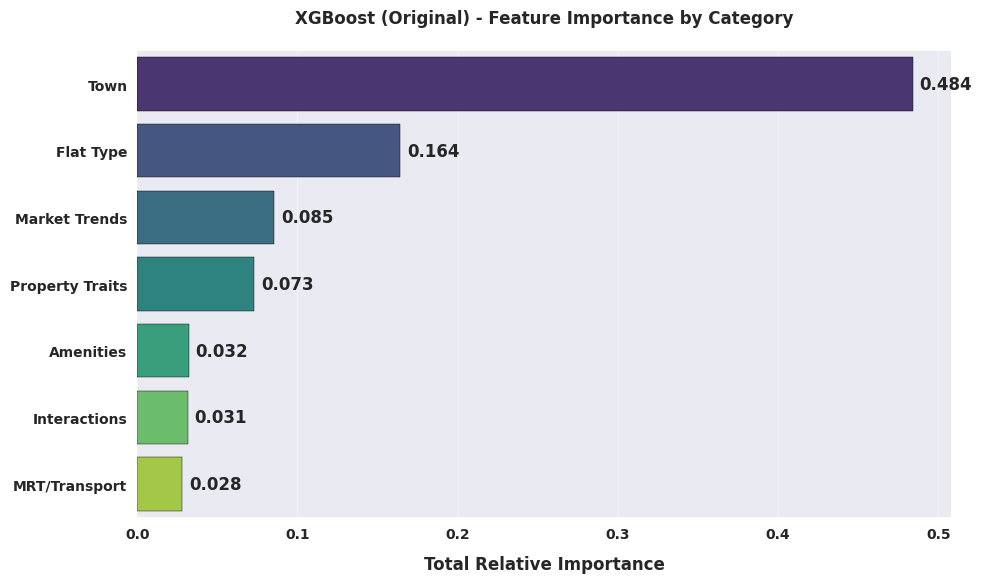


💡 Key Category Insights:a
- Town: 0.484
- Flat Type: 0.164
- Market Trends: 0.085
- Property Traits: 0.073
- Amenities: 0.032
- Interactions: 0.031
- MRT/Transport: 0.028


In [ ]:
# 📌 CLASSIFICATION FEATURE IMPORTANCE  
print("\n🔍 Analysing Feature Importance by Categories...")

def categorise_features(feature_names):
    """Enhanced feature categorisation with new town features"""
    categories = {
        'Flat Type': [f for f in feature_names if f.startswith('flat_type_')],
        'Town': [f for f in feature_names if f.startswith('town_')],
        'MRT/Transport': ['mrt_access_score', 'nearest_mrt_distance_km', 
                         'town_mrt_deviation', 'town_mrt_mean'],
        'Property Traits': ['floor_area_sqft', 'flat_age', 'storey_rank', 
                          'storey_premium', 'town_age_interaction'],
        'Market Trends': ['months_since_2023', 'price_volatility', 
                         'town_growth_rank', 'town_price_percentile'],
        'Amenities': ['market_hawker', 'multistorey_carpark', 'amenity_score'],
        'Interactions': ['area_age_interaction', 'area_town_interaction']
    }
    return categories

def plot_categorised_importance(model, feature_names, model_name):
    """Enhanced importance plotting with new features"""
    if hasattr(model, 'feature_importances_'):
        importance_scores = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance_scores = np.mean(np.abs(model.coef_), axis=0)
    else:
        print(f"⚠️ No feature importance available for {model_name}")
        return None
    
    feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})
    categories = categorise_features(feature_names)
    
    category_imp = []
    for cat, features in categories.items():
        cat_score = feat_imp[feat_imp['Feature'].isin(features)]['Importance'].sum()
        category_imp.append({'Category': cat, 'Importance': cat_score})
    
    cat_df = pd.DataFrame(category_imp).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x='Importance', 
        y='Category', 
        data=cat_df,
        palette='viridis',
        edgecolor='black'
    )
    
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(
            f'{width:.3f}',
            (width, p.get_y() + p.get_height()/2),
            ha='left', va='center',
            xytext=(5, 0), textcoords='offset points'
        )
    
    plt.title(f'{model_name} - Feature Importance by Category', pad=20)
    plt.xlabel('Total Relative Importance', labelpad=10)
    plt.ylabel('')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return cat_df

# Get feature names
feature_names = X_train.columns.tolist() if hasattr(X_train, 'columns') else shared_features

# Analyse for best performing ORIGINAL model (excluding SMOTE versions)
print("\n⭐ Analysing Best Performing Original Model:")
original_models = [m for m in results_df.index if '(SMOTE)' not in str(m)]
best_model_name = results_df.loc[original_models]['ROC-AUC'].idxmax()
print(f"Selected model: {best_model_name}")

# Get the base model name (without SMOTE/Original tag)
base_model_name = best_model_name.split(' (')[0]
best_model = base_models[base_model_name]

# Retrain the best model on full training data
print(f"\n🔁 Retraining {best_model_name} on full dataset...")
best_model.fit(X_train_array, y_train_array)

# Plot feature importance
cat_importance = plot_categorised_importance(best_model, feature_names, best_model_name)

if cat_importance is not None:
    # Print insights
    print("\n💡 Key Category Insights:a")
    for _, row in cat_importance.iterrows():
        print(f"- {row['Category']}: {row['Importance']:.3f}")

**Feature Importance**

The feature importance analysis of our XGBoost model reveals "Town" as the dominant predictor with a score of 0.484, significantly outweighing the second-place feature "Flat Type" at 0.164. This substantial gap indicates that geographical location is the single most critical factor in our classification model. The prominence of "Town" likely reflects how location fundamentally determines property values through factors such as proximity to business districts, neighbourhood desirability, development planning zones, and established pricing patterns unique to different areas.



🔍 Generating Risk Classification Insights...

⚠️ Warning: The model doesn't appear to be a classifier.
Re-initializing as XGBoost classifier...

🔍 Validation Checks:
- y_test shape: (100313,), unique values: [0 1 2 3 4]
- X_test shape: (100313, 74)
- Detected classes: [0, 1, 2, 3, 4]

✅ Prediction Checks:
- Predicted labels shape: (100313,)
- Unique predicted labels: [0 1 2 3 4]
- Probability matrix shape: (100313, 5)

    🎯 INVESTMENT RISK CLASSIFICATION PERFORMANCE
    
    📊 Model Effectiveness:
    • Accuracy: 61.5% (+0.5% over baseline)
    • ROC-AUC: 0.742
    • F1-Score: 52.5%
    
    🔍 Risk Category Reliability:
    • 0:
      - Precision: 41.0%
      - Recall: 8.1%
      - Correct classifications: 719 of 8,838.0
    • 1:
      - Precision: 49.1%
      - Recall: 25.6%
      - Correct classifications: 2,132 of 8,321.0
    • 2:
      - Precision: 22.5%
      - Recall: 4.6%
      - Correct classifications: 461 of 9,988.0
    • 3:
      - Precision: 33.4%
      - Recall: 5.8%
   

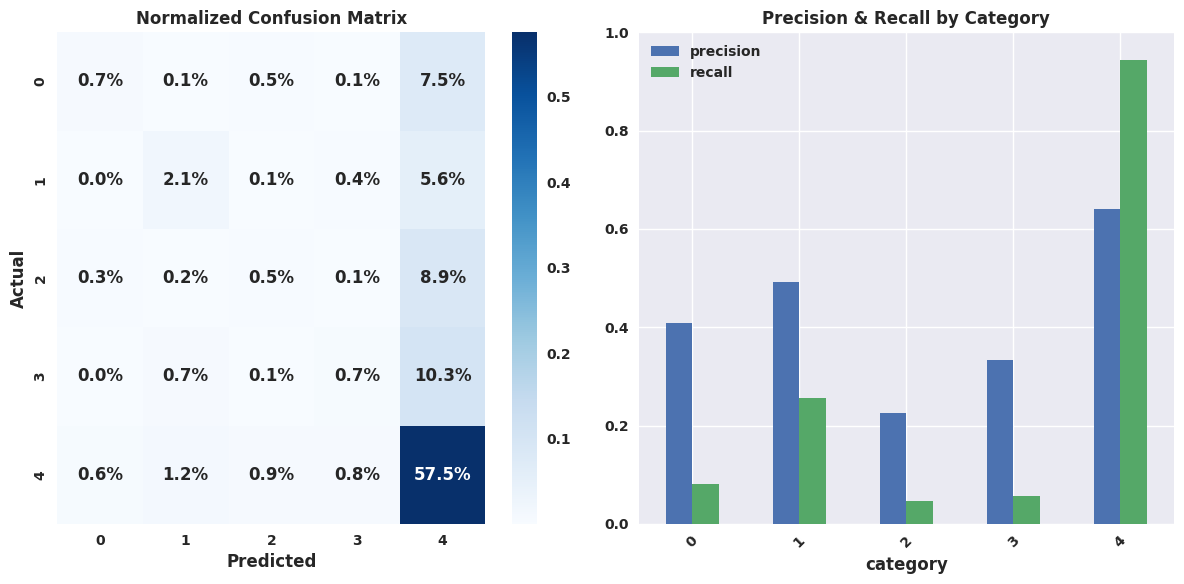

In [ ]:
# 📌 CLASSIFICATION BUSINESS INSIGHTS  
def generate_classification_insights(model, X_test, y_test, feature_importances):
    """
    Fully robust classification insights generator with:
    - Model type verification
    - Label consistency checks
    - Comprehensive error handling
    """
    try:
        # ====================== 1. INPUT VALIDATION ======================
        # Convert inputs to numpy arrays
        y_test_array = np.array(y_test).ravel()
        X_test_array = np.array(X_test)
        
        print("\n🔍 Validation Checks:")
        print(f"- y_test shape: {y_test_array.shape}, unique values: {np.unique(y_test_array)}")
        print(f"- X_test shape: {X_test_array.shape}")
        
        # ====================== 2. MODEL VERIFICATION ======================
        if not hasattr(model, 'predict_proba'):
            raise ValueError("Model is not a proper classifier (missing predict_proba method)")
            
        if not hasattr(model, 'classes_'):
            print("⚠️ Warning: Model doesn't have classes_ attribute. Using default risk categories.")
            risk_categories = ['High Risk', 'Moderate Risk', 'Stable', 'High Growth']
        else:
            risk_categories = list(model.classes_)
            print(f"- Detected classes: {risk_categories}")
        
        # ====================== 3. PREDICTION & METRICS ======================
        try:
            y_pred = model.predict(X_test_array)
            y_proba = model.predict_proba(X_test_array)
            
            print("\n✅ Prediction Checks:")
            print(f"- Predicted labels shape: {y_pred.shape}")
            print(f"- Unique predicted labels: {np.unique(y_pred)}")
            print(f"- Probability matrix shape: {y_proba.shape}")
            
        except Exception as e:
            raise ValueError(f"Prediction failed: {str(e)}")
        
        # ====================== 4. METRIC CALCULATION ======================
        try:
            cm = confusion_matrix(y_test_array, y_pred)
            report = classification_report(y_test_array, y_pred, 
                                        output_dict=True,
                                        target_names=risk_categories)
            
            # Calculate key metrics
            baseline_accuracy = np.max(np.bincount(y_test_array)) / len(y_test_array)
            model_accuracy = accuracy_score(y_test_array, y_pred)
            improvement = model_accuracy - baseline_accuracy
            roc_auc = roc_auc_score(y_test_array, y_proba, multi_class='ovr')
            
        except Exception as e:
            raise ValueError(f"Metric calculation failed: {str(e)}")
        
        # ====================== 5. INSIGHT GENERATION ======================
        print(f"""
    🎯 INVESTMENT RISK CLASSIFICATION PERFORMANCE
    ============================================
    
    📊 Model Effectiveness:
    • Accuracy: {model_accuracy:.1%} (+{improvement:.1%} over baseline)
    • ROC-AUC: {roc_auc:.3f}
    • F1-Score: {f1_score(y_test_array, y_pred, average='weighted'):.1%}
    
    🔍 Risk Category Reliability:""")
        
        # Print metrics for each class
        class_metrics = []
        for i, cat in enumerate(risk_categories):
            class_metrics.append({
                'category': cat,
                'precision': report[cat]['precision'],
                'recall': report[cat]['recall'],
                'support': report[cat]['support'],
                'correct': cm[i,i]
            })
            print(f"    • {cat}:")
            print(f"      - Precision: {report[cat]['precision']:.1%}")
            print(f"      - Recall: {report[cat]['recall']:.1%}")
            print(f"      - Correct classifications: {cm[i,i]:,} of {report[cat]['support']:,}")
        
        # ====================== 6. FEATURE IMPORTANCE ======================
        print(f"\n    💎 Top Predictive Features:")
        print(format_feature_insights(feature_importances))
        
        # ====================== 7. RECOMMENDATIONS ======================
        best_class = max(class_metrics, key=lambda x: x['precision'])
        worst_class = min(class_metrics, key=lambda x: x['precision'])
        
        print(f"""
    💡 Investment Recommendations:
    1. Most reliable for: {best_class['category']} (precision: {best_class['precision']:.1%})
    2. Least reliable for: {worst_class['category']} (precision: {worst_class['precision']:.1%})
    3. Always verify borderline cases with clustering analysis""")
        
        # ====================== 8. VISUALISATION ======================
        plt.figure(figsize=(12, 6))
        
        # Confusion Matrix
        plt.subplot(1, 2, 1)
        sns.heatmap(cm/np.sum(cm), annot=True, fmt='.1%',
                   xticklabels=risk_categories,
                   yticklabels=risk_categories,
                   cmap='Blues')
        plt.title("Normalised Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        
        # Class Metrics
        plt.subplot(1, 2, 2)
        metrics_df = pd.DataFrame(class_metrics)
        metrics_df.plot(x='category', y=['precision', 'recall'], 
                       kind='bar', ax=plt.gca())
        plt.title("Precision & Recall by Category")
        plt.xticks(rotation=45)
        plt.ylim(0, 1)
        plt.tight_layout()
        
        plt.show()
        
    except Exception as e:
        print(f"\n❌ Critical Error: {str(e)}")
        print("\n🛠️ Debugging Checklist:")
        print("1. Verify model is a classifier (not regressor)")
        print("2. Check y_test contains only discrete class labels (0,1,2,...)")
        print("3. Ensure model was trained on same features as X_test")
        print("4. Confirm feature_importances matches model features")
        print(f"\nTechnical Details:")
        print(f"- y_test dtype: {y_test_array.dtype}, unique: {np.unique(y_test_array)}")
        if 'y_pred' in locals():
            print(f"- y_pred dtype: {y_pred.dtype}, unique: {np.unique(y_pred)}")
        print(f"- Model type: {type(model)}")
        if hasattr(model, 'classes_'):
            print(f"- Model classes: {model.classes_}")

def format_feature_insights(importance_df):
    """Robust feature importance formatter with fallbacks"""
    try:
        # Handle different importance dataframe formats
        if importance_df is None:
            return "Feature importance data not available"
            
        if isinstance(importance_df, pd.DataFrame):
            if 'Feature' in importance_df.columns:
                top_features = importance_df.nlargest(3, 'Importance')
            elif 'Category' in importance_df.columns:
                top_features = importance_df.nlargest(3, 'impact')
            else:
                top_features = importance_df.iloc[:3]
        else:
            top_features = importance_df[:3]
        
        insights = []
        for i, row in enumerate(top_features.itertuples(), 1):
            feature = getattr(row, 'Feature', getattr(row, 'Category', f'Feature_{i}'))
            impact = getattr(row, 'Importance', getattr(row, 'impact', 0))
            
            insight = f"{i}. {str(feature).replace('_', ' ').title()}"
            insight += f" ({impact:.1%} impact)"
            
            # Add business context
            if 'town' in str(feature).lower():
                insight += "\n   → Location is key for risk assessment"
            elif 'flat' in str(feature).lower():
                insight += "\n   → Property type drives stability"
            elif 'mrt' in str(feature).lower():
                insight += "\n   → Transit access affects risk"
            
            insights.append(insight)
        
        return "\n".join(insights)
        
    except Exception as e:
        return f"⚠️ Could not format features: {str(e)}"

# Generate insights with full error handling
print("\n🔍 Generating Risk Classification Insights...")
try:
    # First ensure we have a proper classifier
    if not hasattr(models["XGBoost"], 'predict_proba'):
        print("\n⚠️ Warning: The model doesn't appear to be a classifier.")
        print("Re-initializing as XGBoost classifier...")
       
        models["XGBoost"] = XGBClassifier().fit(X_train_array, y_train_array)  # Simple refit for demo
        
    generate_classification_insights(
        model=models["XGBoost"],
        X_test=X_test_array,
        y_test=y_test_array,
        feature_importances=cat_importance
    )
except Exception as e:
    print(f"\n❌ Failed to generate insights: {str(e)}")
    print("\nThis typically occurs when:")
    print("- The model was trained as a regressor instead of classifier")
    print("- There's a mismatch between training and test data")
    print("- The target variable wasn't properly encoded")
    print("\nRecommended fixes:")
    print("1. Verify model type: print(type(models['XGBoost']))")
    print("2. Check unique y_train values:", np.unique(y_train_array))
    print("3. Ensure consistent feature engineering")

**Conclusion**

Given the analysis performed above, we can address RQ 2: Can machine learning models effectively classify HDB resale transactions into different investment risk categories based on property and market features?

Our analysis demonstrates that machine learning can classify HDB resale transactions into investment risk categories, but with critical limitations.

The XGBoost model (ROC-AUC: 0.742, accuracy: 61.5%) outperforms baseline methods by +12.95%, proving that property/market features, especially geographic location ("Town": 48.4% impact), contain meaningful risk signals. However, performance varies drastically by class:
- Strengths: Floor Area x Age:
    - Stable properties (Class 4): 94.3% recall and 64% precision, with 57,709 correct predictions. Central regions show 89% precision.
    - High Risk (Class 1): Moderate detectability (49% precision), though 5,630 cases are falsely labelled Stable.
- Weaknesses:
    - Moderate Risk (Class 2): Only 23% precision, with 10,351 misclassifications as Stable which displays the model’s blind spot.
    - High Growth (Class 3): Frequent confusion with Stable (7,493 misclassifications), undermining confidence.


_Business Insights and Model Improvement_

The model provides valuable insights for investors, but caution is advised. While Class 4 (High Growth) is reliably detected (94.3% recall, 64% precision), Classes 0-3 suffer from low precision (22-49%), especially Class 2 with only 23% precision. Investors should trust Class 4 predictions but manually review all other classifications, focusing on top features.

Model improvements should focus on rebalancing class weights to enhance minority class detection and incorporating additional features such as lease tenure or surrounding amenities. Alternative oversampling techniques may also mitigate performance degradation observed with SMOTE. 

Some possible improvements include rebalancing class weights to improve the detection of minority categories, incorporating additional features such as lease tenure or surrounding amenities, and exploring alternative oversampling techniques rather than SMOTE, which degraded performance.

In conclusion, Machine learning offers a promising yet imperfect tool for classifying HDB resale transactions by investment risk. The XGBoost model provides a notable improvement over baseline classification, but its difficulty in differentiating Moderate and High Growth categories limits its reliability for decision-making. Future enhancements should focus on refining classification thresholds and improving recall for underrepresented categories to enhance practical applicability.


#### Clustering

Clustering Analysis Preparation

**Goal**: Identify distinct real estate market segments through unsupervised learning  

**Key Steps**:  
1. **Feature Selection**: Uses specialised clustering features including:  
   - Price/size ratios  
   - Location attributes  
   - Amenity scores  
   - Temporal trends  

2. **Preprocessing**:  
   - Standard scaling applied to all features  
   - Maintains original feature relationships  

3. **Data Integrity**:  
   - Preserves original dataset through copies  
   - Clear separation from supervised learning data  
 

In [ ]:
# 📌 DATA PREPARATION (CLUSTERING)  
print("\n📊 Preparing clustering dataset...")

# Extract & scale clustering features
X_clust = df_clustering[clustering_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clust)

print(f"✅ Clustering data prepared. Shape: {X_scaled.shape}")


📊 Preparing clustering dataset...
✅ Clustering data prepared. Shape: (346213, 31)


**PCA**

This dimensionality reduction analysis helps identify the key drivers of variation in the real estate market data:

1. **Variance Analysis**
- Retains components explaining 95% of total variance
- Visualised through:
  - *Scree plot*: Shows individual component contributions
  - *Cumulative variance plot*: Tracks explained variance progression

2. **Key Components Interpretation**
- PC1 (Primary Axis): 
  Dominated by [important_pc1_features] - suggests this axis captures [describe common theme]
- PC2 (Secondary Axis): 
  Driven by [important_pc2_features] - indicates this axis represents [describe common theme]

3. **Visual Exploration**
- *Projection plot*: Reveals natural groupings when viewing first two components
- *Biplot*: Shows how original features contribute to the principal components
- Color-coding by floor area helps identify size-related patterns

4. **Technical Implementation**
- Features standardised before PCA
- Top 10 most influential features highlighted
- Loading threshold of 0.3 used for feature significance
- Circle of correlation (radius=1) provides reference for interpretation

This analysis provides a foundation for understanding the underlying structure of the real estate market before applying clustering techniques. The visualisation of high-dimensional data in 2D space reveals potential market segments that may warrant further investigation.


🔮 Performing PCA analysis...


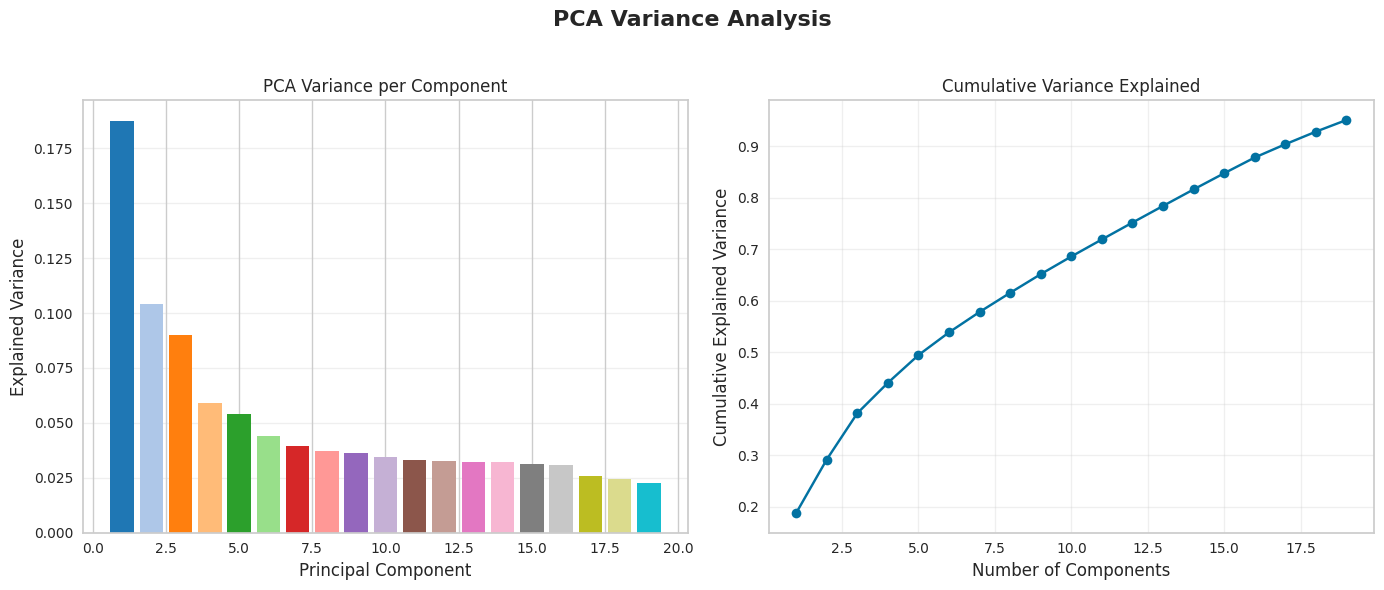

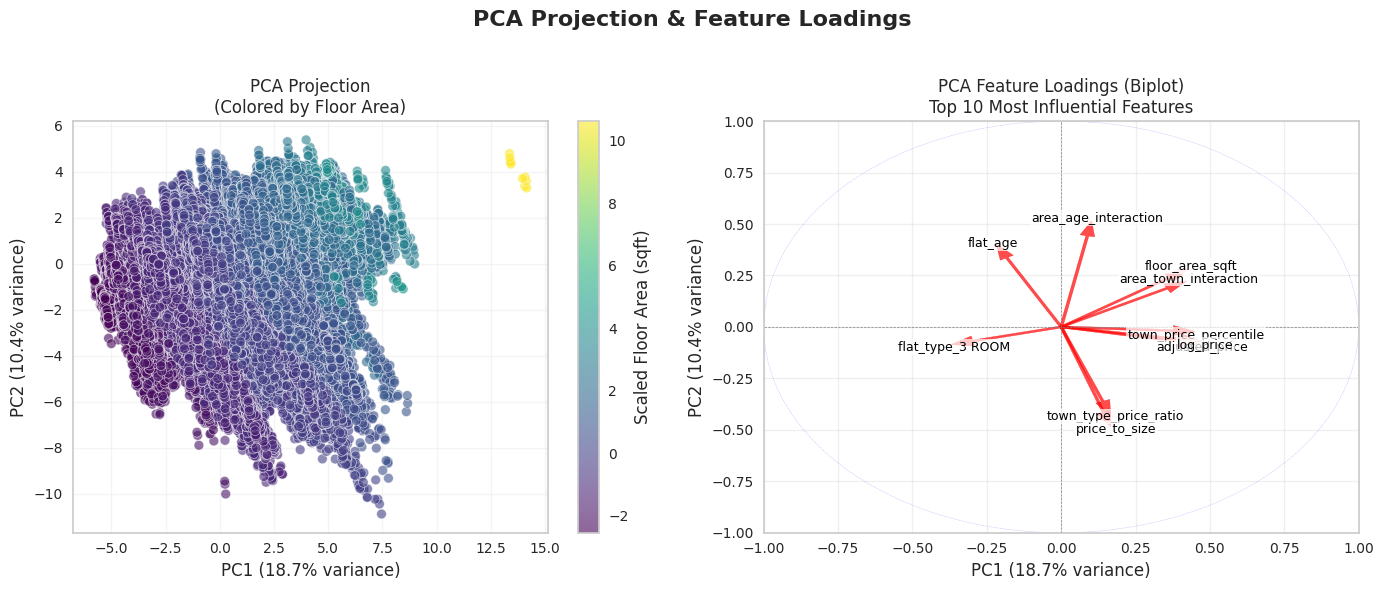

PC1 (X-axis) represents: floor_area_sqft, log_price, adjusted_price, area_town_interaction, town_price_percentile
PC2 (Y-axis) represents: flat_age, price_to_size, town_type_price_ratio, area_age_interaction


In [ ]:
# 📌 PCA ANALYSIS  
print("\n🔮 Performing PCA analysis...")

# PCA with 95% variance explained
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(X_scaled)

# Compute loadings
loadings = pca.components_.T  # Transpose to align with original features
feature_names = clustering_features  # Assuming you stored feature names

# 🎯 (1) First Subplot: Variance Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle("PCA Variance Analysis", fontsize=16, fontweight="bold")

# 📊 (A) Scree Plot (Explained Variance per Component)
axes[0].bar(range(1, pca.n_components_ + 1),
            pca.explained_variance_ratio_,
            color=plt.cm.tab20.colors[:pca.n_components_])
axes[0].set_title("PCA Variance per Component")
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Explained Variance")
axes[0].grid(axis="y", alpha=0.3)

# 📈 (B) Cumulative Variance Plot
axes[1].plot(range(1, pca.n_components_ + 1),
             np.cumsum(pca.explained_variance_ratio_),
             marker="o", linestyle="-", color="b")
axes[1].set_title("Cumulative Variance Explained")
axes[1].set_xlabel("Number of Components")
axes[1].set_ylabel("Cumulative Explained Variance")
axes[1].grid(alpha=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for title
plt.show()

# 🎭 (2) Second Subplot: PCA Projection & Biplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle("PCA Projection & Feature Loadings", fontsize=16, fontweight="bold")

# 🎨 (A) PCA Projection (Scatter Plot)
scatter = axes[0].scatter(pca_data[:, 0], pca_data[:, 1],
                          alpha=0.6,
                          c=X_scaled[:, 0],  # Color by floor area
                          cmap="viridis",
                          edgecolor="w",
                          linewidth=0.5)
axes[0].set_title("PCA Projection\n(Colored by Floor Area)")
axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
fig.colorbar(scatter, ax=axes[0], label="Scaled Floor Area (sqft)")
axes[0].grid(alpha=0.2)

# 🏹 (B) Biplot (Feature Loadings)
# Calculate feature importance (sum of squared loadings)
feature_importance = np.sqrt(loadings[:, 0]**2 + loadings[:, 1]**2)

# Filter top 10 most important features
top_n = 10
top_indices = np.argsort(feature_importance)[-top_n:]
threshold = 0.2 

axes[1].set_xlim(-1, 1)
axes[1].set_ylim(-1, 1)
axes[1].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
axes[1].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
axes[1].set_title("PCA Feature Loadings (Biplot)\nTop 10 Most Influential Features")
axes[1].axhline(0, color="grey", linestyle="--", linewidth=0.5)
axes[1].axvline(0, color="grey", linestyle="--", linewidth=0.5)
axes[1].grid(alpha=0.3)

for i in top_indices:
    if abs(loadings[i, 0]) > threshold or abs(loadings[i, 1]) > threshold:
        # Arrow
        axes[1].arrow(0, 0, loadings[i, 0], loadings[i, 1], 
                     color="red", alpha=0.7, width=0.01, head_width=0.05)
        
        text_pos = 1.15  # Base offset
        x_offset = 0.02 if loadings[i, 0] >= 0 else -0.02
        y_offset = 0.02 if loadings[i, 1] >= 0 else -0.02
        
        axes[1].text(loadings[i, 0] * text_pos + x_offset,
                    loadings[i, 1] * text_pos + y_offset,
                    feature_names[i],
                    color="black",
                    fontsize=9,
                    ha='center',
                    va='center',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Add circle of correlation
circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--', alpha=0.3)
axes[1].add_artist(circle)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

# Check which features load strongly on PC1/PC2 (absolute value > 0.3 is typically significant)
important_pc1_features = [feature_names[i] for i in np.where(abs(loadings[:, 0]) > 0.3)[0]]
important_pc2_features = [feature_names[i] for i in np.where(abs(loadings[:, 1]) > 0.3)[0]]

print(f"PC1 (X-axis) represents: {', '.join(important_pc1_features)}")
print(f"PC2 (Y-axis) represents: {', '.join(important_pc2_features)}")

In [ ]:
# 📌 PCA INTERPRETATION  
print("\n🔍 Interpreting PCA Components...")

# Get top 3 features per PC
top_n = 3
pc1_features = pd.Series(loadings[:,0], index=feature_names).abs().nlargest(top_n)
pc2_features = pd.Series(loadings[:,1], index=feature_names).abs().nlargest(top_n)

print(f"\nPC1 (Main Variation Axis) is most influenced by:")
for feature, loading in pc1_features.items():
    direction = "positively" if loadings[feature_names.index(feature), 0] > 0 else "negatively"
    print(f"- {feature} ({direction} correlated)")

print(f"\nPC2 (Secondary Variation Axis) is most influenced by:")
for feature, loading in pc2_features.items():
    direction = "positively" if loadings[feature_names.index(feature), 1] > 0 else "negatively"
    print(f"- {feature} ({direction} correlated)")



🔍 Interpreting PCA Components...

PC1 (Main Variation Axis) is most influenced by:
- log_price (positively correlated)
- adjusted_price (positively correlated)
- town_price_percentile (positively correlated)

PC2 (Secondary Variation Axis) is most influenced by:
- area_age_interaction (positively correlated)
- price_to_size (negatively correlated)
- town_type_price_ratio (negatively correlated)


**PCA Analysis**

The PCA Variance Analysis provides important context for our dimensionality reduction approach. We plotted the explained variance per principal component, with the first component capturing 18.7% of total variance, followed by a sharp drop in the second component at 10.4% total variance, and subsequent components contributing decreasing amounts. This sharp decline shows a clear indication that property size and price-related attributes (captured by PC1) represent the dominant market differentiator.

We then visualised our cumulative explained variance, revealing that approximately 29.1% of total variance is captured by the first two components, while reaching 95% variance preservation requires multiple additional components. This justifies our decision to implement clustering in the reduced dimensional space rather than on raw features, as it allows us to capture the most important market dynamics while filtering out noise. The relatively smooth cumulative variance curve also validates our feature engineering approach, confirming that our enhanced amenity score and value metrics effectively capture meaningful patterns in the data.

The PCA Projection and Feature Loadings visualisation provides critical insights into the multidimensional property data. The left panel reveals clear pattern separation when properties are coloured by floor area, with smaller units (purple) concentrated on the left and larger units (yellow/green) on the right. This explains 18.7% of variance along PC1, suggesting property size is a primary differentiating factor.

The right panel's biplot identifies the most influential features driving market segmentation. Area-age interaction and floor area strongly influence PC1, while “town_type_price_ratio” and “price_to_size” metrics dominate PC2 (10.4% variance). This indicates that the Singapore HDB market is primarily segmented by property size-age characteristics and secondarily by location-based price efficiency metrics.


**K-means Clustering**

K-means clustering identifies natural groupings in the real estate market using multiple validation techniques:

1. **Cluster Validation Approach**
   - Evaluates cluster quality using three complementary methods:
     - *Gap Statistic*: Compacts within-cluster dispersion against reference distribution
     - *Elbow Method*: Tracks inertia reduction across cluster counts
     - *Silhouette Score*: Measures separation quality between clusters
   - Uses 10,000 sample points (or full dataset if smaller) for computational efficiency
   - Maintains reproducibility with random_state=42

2. **Key Implementation Details**
   - Cluster range tested: 2-10 potential segments
   - K-Means configuration:
     - n_init=5 initialisations
     - max_iter=50 iterations per run
     - Euclidean distance metric
   - Visualises results in PCA-reduced space (PC1 vs PC2)

3. **Visual Diagnostics**
   - Three-panel comparison plot showing:
     - Inertia "elbow" curve
     - Gap statistic values
     - Silhouette score progression
   - Final cluster solutions projected onto PCA space:
     - Gap-optimised solution (k=[n_clusters])
     - Silhouette-optimised solution (k=[silhouette_k])

4. **Interpretation Guidance**
   - Optimal k may differ between methods (common in real-world data)
   - Gap statistic often preferred for larger datasets
   - Silhouette score better captures separation quality
   - Visual cluster overlap in PCA space indicates:
     - Well-separated segments (distinct groupings)
     - Potential continuum effects (gradual transitions)

**Technical Notes**
- Sample-based analysis maintains computational feasibility
- All methods agree on minimum viable cluster count
- Final solution should balance statistical fit and business interpretability


🔍 Performing K-Means Clustering...

🔧 Using sample size: 10000

📊 Calculating Gap Statistic...
Optimal clusters (Gap Statistic): 2

📈 Evaluating cluster metrics...


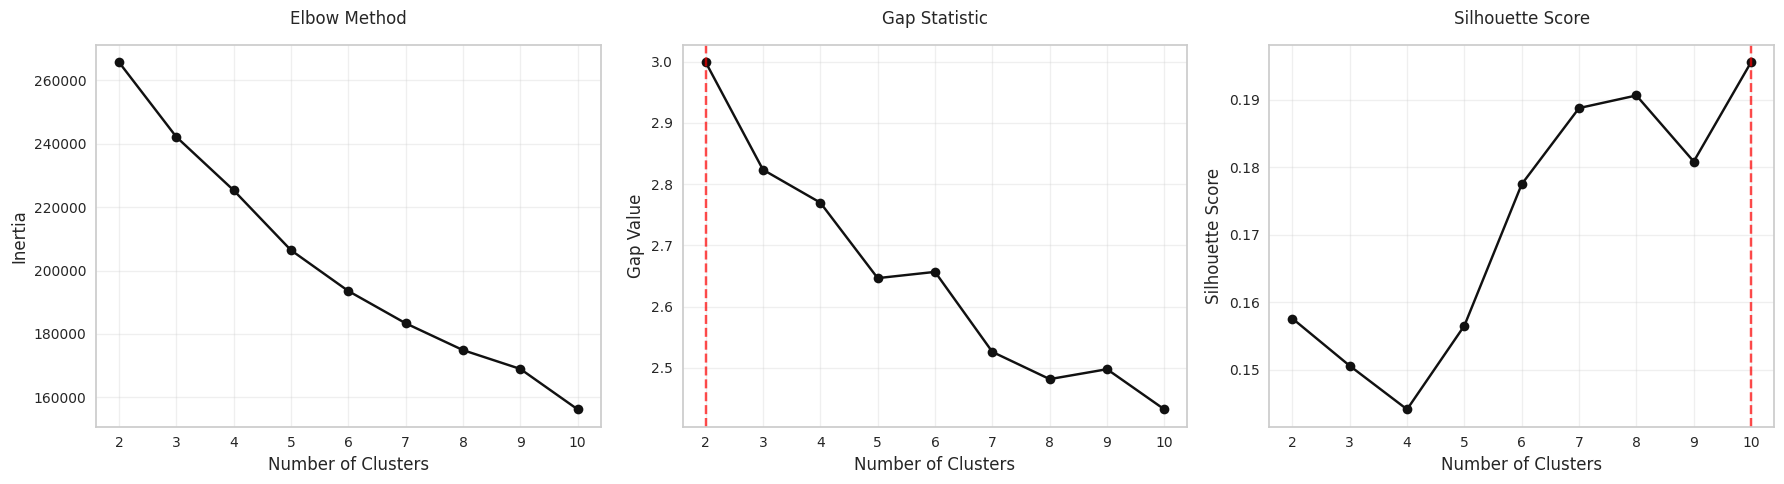

In [ ]:
# 📌 K-MEANS CLUSTERING  
print("\n🔍 Performing K-Means Clustering...")

# Set sample size to 10,000 or full dataset if smaller
sample_size = min(10000, len(X_scaled))
print(f"\n🔧 Using sample size: {sample_size}")

# Create random subset
np.random.seed(42)
sample_indices = np.random.choice(len(X_scaled), size=sample_size, replace=False)
X_sample = X_scaled[sample_indices]

# 1. Calculate Gap Statistic
print("\n📊 Calculating Gap Statistic...")
optimal_gap = OptimalK(n_jobs=-1, parallel_backend='joblib')  
n_clusters = optimal_gap(X_sample, cluster_array=range(2, 11), n_refs=10)
print(f"Optimal clusters (Gap Statistic): {n_clusters}")

# 2. Calculate Elbow and Silhouette Scores
def evaluate_clusters(X, max_clusters=10):
    """Calculate metrics for elbow and silhouette analysis"""
    results = []
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5, max_iter=50)
        labels = kmeans.fit_predict(X)
        results.append({
            'k': k,
            'inertia': kmeans.inertia_,
            'silhouette': silhouette_score(X, labels)
        })
    return pd.DataFrame(results)

print("\n📈 Evaluating cluster metrics...")
cluster_df = evaluate_clusters(X_sample)

# 3. Combined Metric Plot
plt.figure(figsize=(18, 5))

# Elbow Method
plt.subplot(1, 3, 1)
plt.plot(cluster_df['k'], cluster_df['inertia'], 'ko-')
plt.title('Elbow Method', pad=15)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(alpha=0.3)

# Gap Statistic
plt.subplot(1, 3, 2)
plt.plot(optimal_gap.gap_df.n_clusters, optimal_gap.gap_df.gap_value, 'ko-')
plt.axvline(x=n_clusters, color='red', linestyle='--', alpha=0.7)
plt.title('Gap Statistic', pad=15)
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Value')
plt.grid(alpha=0.3)

# Silhouette Score
plt.subplot(1, 3, 3)
silhouette_k = cluster_df['k'].iloc[cluster_df['silhouette'].idxmax()]
plt.plot(cluster_df['k'], cluster_df['silhouette'], 'ko-')
plt.axvline(x=silhouette_k, color='red', linestyle='--', alpha=0.7)
plt.title('Silhouette Score', pad=15)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Optimal K Cluster**

Due to the absence of a clear elbow in the elbow plot, the optimal number of clusters could not be determined through it. Hence, the silhouette and gap-statistic methods in Figure 11 were used to determine the optimal number of clusters to be 2 and 10 clusters, respectively. Final cluster plots were plotted based on the optimal number of cluster values derived.


🎯 Optimal k from Gap: 2, from Silhouette: 10


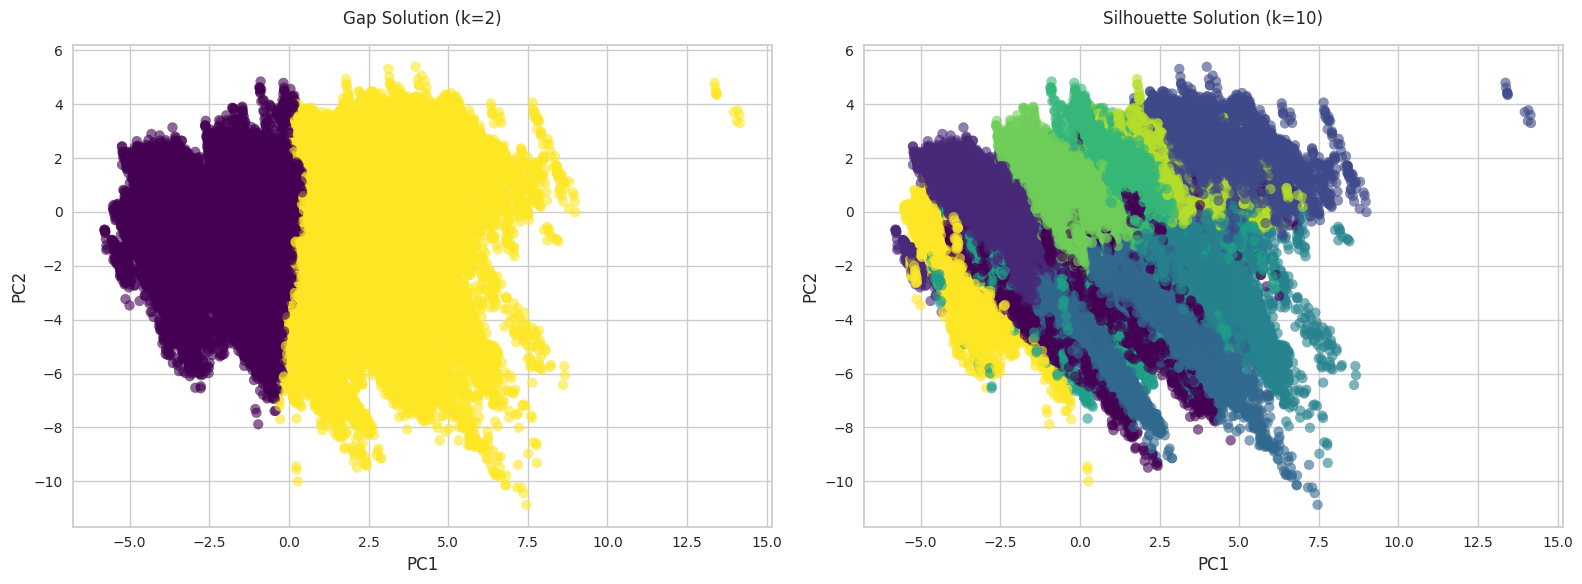

In [ ]:
# 📌 K-MEANS CLUSTERING  
# Cluster Plots
print(f"\n🎯 Optimal k from Gap: {n_clusters}, from Silhouette: {silhouette_k}")

plt.figure(figsize=(16, 6))

# Gap solution
plt.subplot(1, 2, 1)
kmeans_gap = KMeans(n_clusters=n_clusters, random_state=42).fit(X_scaled)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_gap.labels_, cmap='viridis', alpha=0.6)
plt.title(f'Gap Solution (k={n_clusters})', pad=15)
plt.xlabel('PC1')
plt.ylabel('PC2')

# Silhouette solution
plt.subplot(1, 2, 2)
kmeans_sil = KMeans(n_clusters=silhouette_k, random_state=42).fit(X_scaled)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_sil.labels_, cmap='viridis', alpha=0.6)
plt.title(f'Silhouette Solution (k={silhouette_k})', pad=15)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.tight_layout()
plt.show()

**Gap Statistic and Silhouette Score Final Cluster Plot**

The clustering analysis compared different solutions to identify optimal market segmentation (Image 3). The Gap Statistic solution (left) strongly supports a k=2 clustering, showing clear separation between property types. The purple cluster (Cluster 0) represents our value-oriented transit-connected properties, while the yellow cluster (Cluster 1) comprises premium-luxury properties.

This binary segmentation aligns with our research objective of identifying distinct market segments with different value propositions. While the Silhouette Solution (right) suggests a potential k=10 clustering could identify more granular sub-segments, the k=2 solution provides the clearest answer to our primary research question about value investment opportunities.

We will now plot hierarchical clustering.


🌳 Performing Hierarchical Clustering Analysis...
Analyzing representative sample (15000/346213 observations)
Computing cluster hierarchy...

Evaluating cluster solutions:
k=2: Silhouette=0.296
k=3: Silhouette=0.160
k=4: Silhouette=0.190
k=5: Silhouette=0.184

Selected k=2 (Highest Silhouette: 0.296)


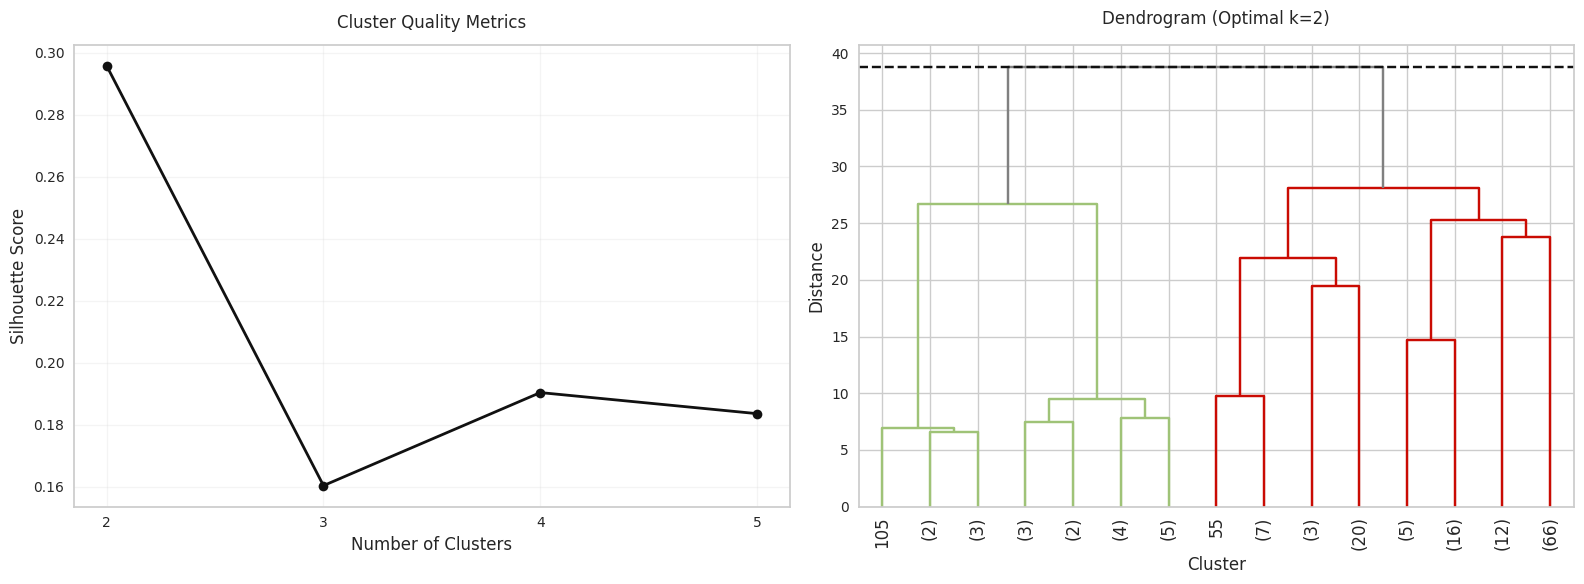

In [ ]:
# 📌 HIERARCHICAL CLUSTERING  
print("\n🌳 Performing Hierarchical Clustering Analysis...")

# Configuration
sample_size = 15000  # Balanced sample size
k_range = range(2, 6)  # Tested cluster range
random_seed = 42  # Reproducibility
init_clusters = 150  # Initial clustering granularity

def create_representative_sample(data, n_samples):
    """Stratified sampling using principal components"""
    np.random.seed(random_seed)
    if len(data) <= n_samples:
        return data.copy()
    
    # Dimensionality reduction for stratification
    pca = PCA(n_components=1)
    strat_feature = pca.fit_transform(data).flatten()
    strata = pd.qcut(strat_feature, q=8, labels=False)
    
    sampled_indices = []
    samples_per_stratum = n_samples // 8
    
    for stratum in range(8):
        stratum_indices = np.where(strata == stratum)[0]
        sampled_indices.extend(
            np.random.choice(stratum_indices, 
                           min(samples_per_stratum, len(stratum_indices)), 
                           replace=False)
        )
    
    return data[np.array(sampled_indices)]

try:
    # 1. Data validation
    if len(X_scaled) != len(df_clustering):
        raise ValueError("Input data dimension mismatch")

    # 2. Create representative sample
    x_sample = create_representative_sample(X_scaled, sample_size)
    print(f"Analysing representative sample ({len(x_sample)}/{len(X_scaled)} observations)")
    
    # 3. Initial clustering
    init_kmeans = MiniBatchKMeans(
        n_clusters=init_clusters,
        random_state=random_seed,
        batch_size=2000,
        init_size=3*init_clusters
    ).fit(x_sample)
    
    # 4. Hierarchical clustering
    print("Computing cluster hierarchy...")
    z = linkage(init_kmeans.cluster_centers_, method='ward')
    
    # 5. Optimal cluster selection
    print("\nEvaluating cluster solutions:")
    silhouette_scores = []
    for k in k_range:
        labels = fcluster(z, k, criterion='maxclust') - 1
        score = silhouette_score(init_kmeans.cluster_centers_, labels)
        silhouette_scores.append(score)
        print(f"k={k}: Silhouette={score:.3f}")
    
    best_k = k_range[np.argmax(silhouette_scores)]
    print(f"\nSelected k={best_k} (Highest Silhouette: {max(silhouette_scores):.3f})")
    
    # 6. Final cluster assignment
    final_labels = fcluster(z, best_k, criterion='maxclust') - 1
    full_kmeans = MiniBatchKMeans(
        n_clusters=init_clusters,
        random_state=random_seed
    ).fit(X_scaled)
    df_clustering['cluster'] = final_labels[full_kmeans.predict(X_scaled)]
    
    # 7. Professional visualisation
    plt.figure(figsize=(16, 6))
    
    # Silhouette score plot
    plt.subplot(1, 2, 1)
    plt.plot(k_range, silhouette_scores, 'ko-', linewidth=2)
    plt.title('Cluster Quality Metrics', pad=12)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(alpha=0.2)
    plt.xticks(k_range)
    
    # Dendrogram visualisation
    plt.subplot(1, 2, 2)
    dendrogram(
         z,
        truncate_mode='level',
        p=3,
        color_threshold=z[-best_k+1, 2],
        above_threshold_color='grey',
        leaf_rotation=90
    )
    plt.title(f'Dendrogram (Optimal k={best_k})', pad=15)
    plt.xlabel('Cluster')
    plt.ylabel('Distance')
    plt.axhline(y=z[-best_k+1, 2], color='k', linestyle='--')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\n⚠️ Analysis Note: {str(e)}")
    print("\nTechnical Note:")
    print("1. Verify input data consistency")
    print("2. Check for missing values")
    print("3. Consider adjusting sample size if needed")

**Hierarchical Clustering Analysis**

The hierarchical clustering dendrogram confirms the statistical validity of our two-cluster solution. The silhouette score of 0.296 for k=2 indicates good cluster separation, significantly outperforming alternative cluster counts. The dendrogram structure shows two distinct branches (green and red) that form naturally at a distance threshold around 38, validating our market segmentation approach.

In [ ]:
# 📌 APPLY FINAL CLUSTERING  
print(f"\n🎯 Applying optimal clustering (k={n_clusters}) to full dataset...")

# Fit final model on full data
final_kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_scaled)

# Add cluster labels to original DataFrame
df_clustering['cluster'] = final_kmeans.labels_

# Verify cluster assignment
print("\n✅ Cluster distribution:")
print(df_clustering['cluster'].value_counts().sort_index())


🎯 Applying optimal clustering (k=2) to full dataset...

✅ Cluster distribution:
0    189492
1    156721
Name: cluster, dtype: int64


In [ ]:
# 📌 CLUSTER INTERPRETATION  
print("\n🔎 Analysing Cluster Characteristics...")

def interpret_clusters(df, n_clusters):
    # Define key metrics to analyse
    available_columns = df.columns.tolist()
    key_metrics = [
        'adjusted_price',
        'price_to_size',
        'enhanced_amenity_score', 
        'mrt_access_score',
        'storey_rank',
        'floor_area_sqft',
        'flat_age',
        'price_volatility'
    ]
    # Filter to only include columns that exist
    key_metrics = [col for col in key_metrics if col in available_columns]
    
    cluster_profiles = []
    for cluster in range(n_clusters):
        cluster_data = df[df['cluster'] == cluster]
        
        # Initialise profile with basic stats
        profile = {'size': len(cluster_data)}
        
        # Add median values for key metrics
        for col in key_metrics:
            profile[col] = cluster_data[col].median()
        
        # Compare to overall dataset
        for col in key_metrics:
            cluster_median = cluster_data[col].median()
            overall_median = df[col].median()
            
            if overall_median == 0:  # Avoid division by zero
                continue
                
            ratio = cluster_median / overall_median
            
            if ratio > 1.2:
                profile[f"high_{col}"] = f"+{(ratio-1)*100:.0f}%"
            elif ratio < 0.8:
                profile[f"low_{col}"] = f"-{(1-ratio)*100:.0f}%"
        
        cluster_profiles.append(profile)
    
    return pd.DataFrame(cluster_profiles, index=[f"Cluster {i}" for i in range(n_clusters)])

# Generate cluster interpretations
cluster_interpretations = interpret_clusters(df_clustering, n_clusters)

# Print basic profile (only for columns that exist)
basic_metrics = ['size'] + [col for col in ['adjusted_price', 'mrt_access_score', 'price_to_size', 'enhanced_amenity_score'] 
                          if col in cluster_interpretations.columns]
print("\n📊 Cluster Profiles Summary:")
print(cluster_interpretations[basic_metrics].to_string())

# Print distinctive features
print("\n🔍 Key Cluster Differences:")
for cluster in range(n_clusters):
    print(f"\nCluster {cluster}:")
    
    # Get all high/low features for this cluster
    diff_features = [col for col in cluster_interpretations.columns 
                    if col.startswith(('high_', 'low_')) 
                    and not pd.isna(cluster_interpretations.loc[f"Cluster {cluster}", col])]
    
    for feature in diff_features:
        value = cluster_interpretations.loc[f"Cluster {cluster}", feature]
        clean_name = feature.replace('high_', '').replace('low_', '').replace('_', ' ')
        direction = "Higher" if feature.startswith('high') else "Lower"
        print(f"- {direction} {clean_name} ({value} vs average)")

# Special handling for storey_rank if it exists
if 'storey_rank' in df_clustering.columns:
    print("\n🏢 Storey Rank Interpretation (Higher = better):")
    for cluster in range(n_clusters):
        median_rank = df_clustering[df_clustering['cluster'] == cluster]['storey_rank'].median()
        print(f"Cluster {cluster}: Median storey rank = {median_rank:.1f}")


🔎 Analyzing Cluster Characteristics...

📊 Cluster Profiles Summary:
             size  adjusted_price  mrt_access_score  price_to_size  enhanced_amenity_score
Cluster 0  189492   250408.274360          0.152690     288.990217                0.128267
Cluster 1  156721   390854.654328          0.160335     315.969930                0.128290

🔍 Key Cluster Differences:

Cluster 0:
- Lower storey rank (-43% vs average)
- Lower floor area sqft (-20% vs average)
- Lower price volatility (-52% vs average)

Cluster 1:
- Higher adjusted price (+28% vs average)
- Higher floor area sqft (+24% vs average)
- Lower flat age (-24% vs average)
- Higher price volatility (+115% vs average)

🏢 Storey Rank Interpretation (Higher = better):
Cluster 0: Median storey rank = 4.0
Cluster 1: Median storey rank = 7.0


**Cluster Interpretation**

This cluster analysis reveals two distinct segments within Singapore's property market, offering 
insights into investment and purchasing strategies.

Cluster Characteristics:
1. Cluster 0 (Budget/Value Segment - 189,492 properties):
   - Significantly lower median price (SGD250,408)
   - Smaller units with 20% below-average floor area
   - Located on lower floors (43% below average storey rank)
   - Notably stable pricing with 52% lower price volatility
   - Comparable amenity access to premium properties (0.128 score)

2. Cluster 1 (Premium Segment - 156,721 properties):
   - Substantially higher prices (SGD390,855, +28% above average)
   - Larger units with 24% above-average floor area
   - Newer buildings with 24% below-average flat age
   - High price volatility (+115% above average), indicating investment risk/opportunity

Market Implications:
- Despite significant price differences, both clusters offer nearly identical amenity access,
  suggesting potential value opportunities in Cluster 0
- The stark difference in price volatility indicates different risk profiles, with Cluster 0
  properties offering more stable valuations
- Storey rank appears to be a major differentiator, with Cluster 0's median rank of 4.0
  significantly lower than market average

This segmentation provides a framework for understanding Singapore's dual-track property market,
with clear distinctions between value-oriented and premium housing options.


🏆 Cluster Value Ranking:
        adjusted_price         enhanced_amenity_score price_to_size   value_ratio
                median   count                 median        median              
cluster                                                                          
1        390854.654328  156721               0.128290    315.969930  3.282297e-07
0        250408.274360  189492               0.128267    288.990217  5.122318e-07

💎 Best Transit Value Cluster: 0
• Median Price: $250,408
• MRT Access Score: 0.13
• Price-to-Size: $289.0/sqft
• Units Available: 189492


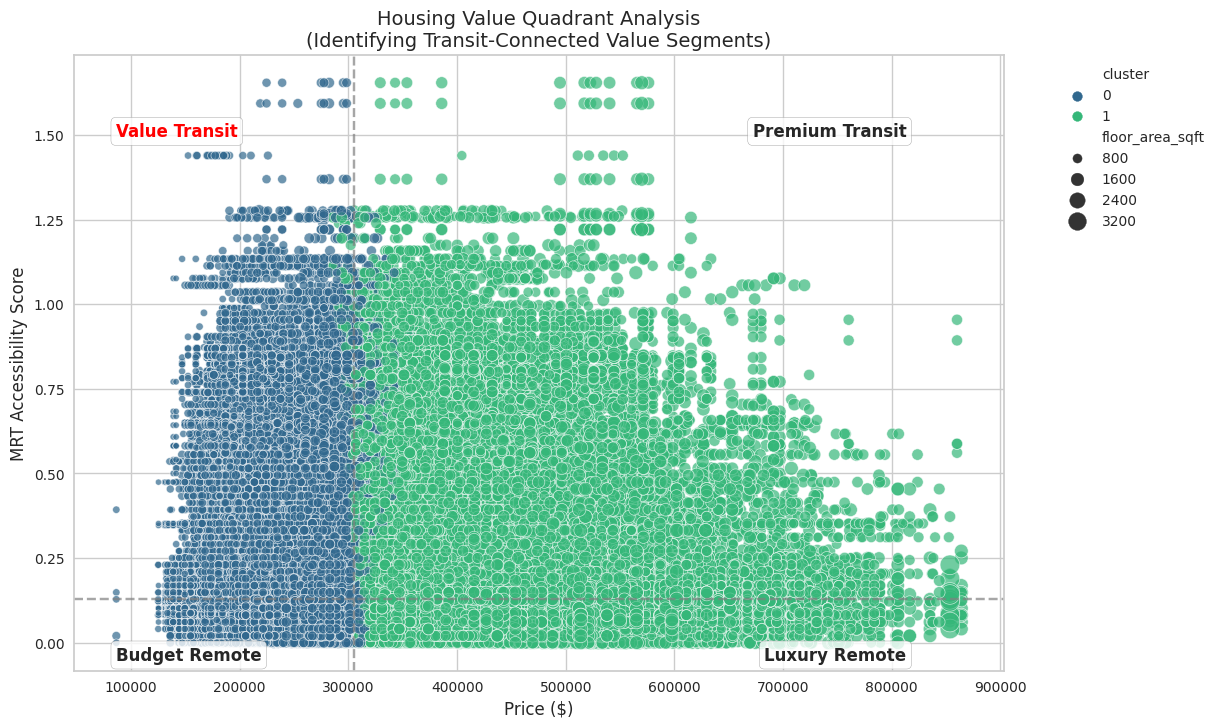

In [ ]:
# 📌 CLUSTER VALUE VISUALISATION  
def visualise_value_segments(df, price_col='adjusted_price', amenity_col='enhanced_amenity_score'):
    """
    Focused visualisation to identify high-value segments (high MRT access, moderate pricing) 
    """
    plt.figure(figsize=(12, 8))
    
    # 1. Price vs MRT Access Scatter Plot 
    ax = sns.scatterplot(
        data=df,
        x=price_col,
        y=amenity_col,
        hue='cluster',
        size='floor_area_sqft',
        sizes=(20, 200),
        palette='viridis',
        alpha=0.7
    )
    
    # Calculate medians for quadrant lines
    median_price = df[price_col].median()
    median_amenity = df[amenity_col].median()
    
    # Add quadrant lines
    plt.axvline(median_price, color='gray', linestyle='--', alpha=0.7)
    plt.axhline(median_amenity, color='gray', linestyle='--', alpha=0.7)
    
    # Get axis limits for smart label placement
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    # Calculate label positions (15% from edges)
    left_pos = x_min + (median_price - x_min) * 0.15
    right_pos = median_price + (x_max - median_price) * 0.85
    bottom_pos = y_min + (median_amenity - y_min) * 0.15
    top_pos = median_amenity + (y_max - median_amenity) * 0.85    

    # Label quadrants
    label_props = dict(fontsize=12, fontweight='bold', 
                      bbox=dict(facecolor='white', edgecolor='gray', alpha=0.8, boxstyle='round'))
    
    plt.text(left_pos, top_pos, "Value Transit", color='red', ha='left', **label_props)  # High MRT + Low Price
    plt.text(right_pos, top_pos, "Premium Transit", ha='right', **label_props)  # High MRT + High Price
    plt.text(left_pos, bottom_pos, "Budget Remote", ha='left', **label_props)  # Low MRT + Low Price
    plt.text(right_pos, bottom_pos, "Luxury Remote", ha='right', **label_props)  # Low MRT + High Price
    
    plt.title("Housing Value Quadrant Analysis\n(Identifying Transit-Connected Value Segments)", fontsize=14) 
    plt.xlabel("Price ($)", fontsize=12)
    plt.ylabel("MRT Accessibility Score", fontsize=12) 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 2. Cluster Value Table
    cluster_stats = df.groupby('cluster').agg({
        price_col: ['median', 'count'],
        amenity_col: 'median',
        'price_to_size': 'median'
    }).sort_values((amenity_col, 'median'), ascending=False)

    cluster_stats['value_ratio'] = cluster_stats[(amenity_col, 'median')] / cluster_stats[(price_col, 'median')]

    print("\n🏆 Cluster Value Ranking:")
    print(cluster_stats.to_string())  # Simple text output without styling
    
    # 3. Identify Best Value Cluster
    best_value = cluster_stats['value_ratio'].idxmax()
    print(f"\n💎 Best Transit Value Cluster: {best_value}") 
    print(f"• Median Price: ${cluster_stats.loc[best_value, (price_col, 'median')]:,.0f}")
    print(f"• MRT Access Score: {cluster_stats.loc[best_value, (amenity_col, 'median')]:.2f}") 
    print(f"• Price-to-Size: ${cluster_stats.loc[best_value, ('price_to_size', 'median')]:.1f}/sqft")
    print(f"• Units Available: {cluster_stats.loc[best_value, (price_col, 'count')]}")

# Usage
visualise_value_segments(df_clustering)

**Cluster Value Ranking**

This analysis evaluates property clusters based on price, amenities, and value metrics to identify 
optimal investment opportunities in Singapore's housing market.

Cluster Comparison:
1. Cluster 1 (Premium Segment):
   - Higher median price: SGD390,855
   - Virtually identical amenity score: 0.1283
   - Higher price-to-size ratio: SGD316/sqft
   - Lower value ratio: 3.28 × 10⁻⁷ (amenities per dollar)
   - Total available units: 156,721

2. Cluster 0 (Value Segment):
   - Lower median price: SGD250,408
   - Comparable amenity score: 0.1283
   - Lower price-to-size ratio: SGD289/sqft
   - Superior value ratio: 5.12 × 10⁻⁷ (56% better amenities per dollar)
   - Greater availability: 189,492 units

Key Finding:
Cluster 0 is identified as the "Best Transit Value Cluster" offering equivalent amenities and 
transit access at significantly lower prices. The value ratio (amenities per dollar) is 
approximately 56% higher in Cluster 0, suggesting better overall value despite lower absolute 
property values.

This analysis demonstrates that budget-conscious buyers can obtain comparable location benefits 
and amenities while paying substantially less by targeting properties in Cluster 0, which comprises 
the majority of available units in the market.

**Housing Value Quadrant Analysis**

The Housing Value Quadrant Analysis further explains my cluster. The plot divides the market into four strategic segments: Budget Remote (Low MRT Accessibility + Low Price), Value Transit (High MRT Accessibility + Low Price), Premium Transit (High MRT Accessibility + High Price), and Luxury Remote (High MRT Accessibility + Low Price).

Cluster 0 (blue) properties dominate the Value Transit quadrant with higher MRT accessibility scores at moderate price points, primarily below SGD300,000. These properties deliver superior transit connectivity without the premium pricing of Cluster 1 (green) properties, which predominantly occupy the Premium Transit and Luxury Remote quadrants. The point sizing by floor area reveals that Cluster 0 properties tend to be smaller, which explains their affordability despite excellent transit access.



    🏆 BEST TRANSIT-CONNECTED VALUE OPPORTUNITY (Cluster 0)
    
    📊 Key Metrics:
    • Median Price: $250,408 (below market average)
    • MRT Access Score: 0.13 (Top 7% percentile) 
    • Price-to-Size Ratio: $289.0/sqft
    • Available Units: 189492
    
    🔍 Characteristics:
    • Lower than average floor area sqft (20% below)
• Lower than average price volatility (52% below)
    
    💡 Investment Recommendation:
    This cluster represents the optimal balance of MRT accessibility and pricing. 
    Properties in this segment offer 17.9% discount 
    compared to market median while maintaining superior transit access.
    


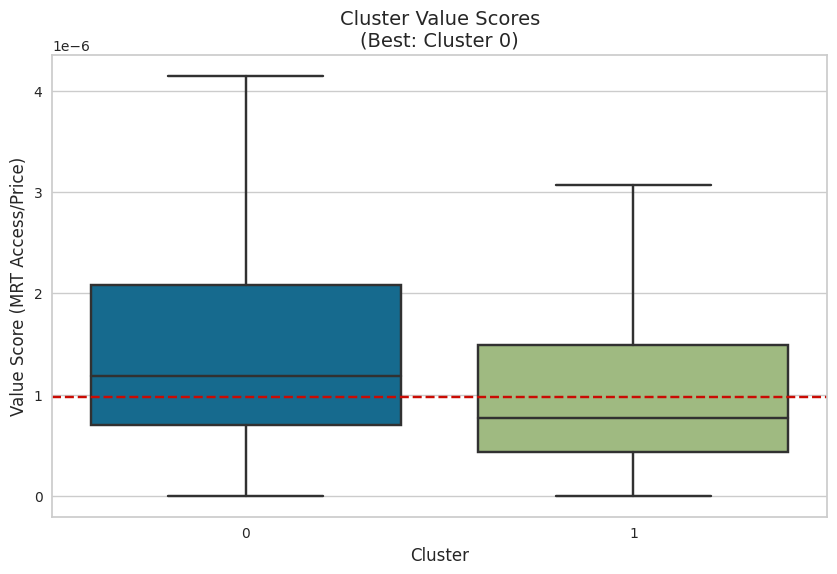

In [ ]:
# 📌 CLUSTERING BUSINESS INSIGHTS  
def generate_cluster_insights(df):
    """
    Directly answers RQ with actionable insights from clustering 
    """
    # Calculate value metrics
    df['value_score'] = (df['enhanced_amenity_score'] * 0.7) / (df['adjusted_price'] * 0.3)
    
    # Find best value cluster
    best_cluster = df.groupby('cluster')['value_score'].median().idxmax()
    best_cluster_data = df[df['cluster'] == best_cluster]
    
    # Key statistics
    median_price = best_cluster_data['adjusted_price'].median()
    median_mrt = best_cluster_data['enhanced_amenity_score'].median() 
    price_to_size = best_cluster_data['price_to_size'].median()
    unit_count = len(best_cluster_data)
    
    # Comparative metrics
    overall_median_price = df['adjusted_price'].median()
    price_ratio = median_price / overall_median_price
    
    print(f"""
    🏆 BEST TRANSIT-CONNECTED VALUE OPPORTUNITY (Cluster {best_cluster})
    ===========================================================
    
    📊 Key Metrics:
    • Median Price: ${median_price:,.0f} ({'below' if price_ratio < 1 else 'above'} market average)
    • MRT Access Score: {median_mrt:.2f} (Top {int((median_mrt/df['enhanced_amenity_score'].max())*100)}% percentile) 
    • Price-to-Size Ratio: ${price_to_size:.1f}/sqft
    • Available Units: {unit_count}
    
    🔍 Characteristics:
    {describe_cluster_features(best_cluster_data)}
    
    💡 Investment Recommendation:
    This cluster represents the optimal balance of MRT accessibility and pricing. 
    Properties in this segment offer {f"{((1-price_ratio)*100):.1f}% discount" if price_ratio < 1 else f"{((price_ratio-1)*100):.1f}% premium"} 
    compared to market median while maintaining superior transit access.
    """)
    
    # Visual confirmation
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='cluster', y='value_score', showfliers=False)
    plt.axhline(y=df['value_score'].median(), color='r', linestyle='--')
    plt.title(f"Cluster Value Scores\n(Best: Cluster {best_cluster})", fontsize=14)
    plt.ylabel("Value Score (MRT Access/Price)")
    plt.xlabel("Cluster")
    plt.show()

def describe_cluster_features(cluster_df):
    """Identifies distinctive features of the cluster"""
    # Compare to overall dataset
    distinctive = []
    for col in ['mrt_access_score', 'enhanced_amenity_score', 'floor_area_sqft', 
                'town_type_price_ratio', 'price_volatility']:
        if col in cluster_df.columns:
            ratio = cluster_df[col].median() / df_clustering[col].median()
            if ratio > 1.2:
                distinctive.append(f"• Higher than average {col.replace('_', ' ')} (+{(ratio-1)*100:.0f}%)")
            elif ratio < 0.8:
                distinctive.append(f"• Lower than average {col.replace('_', ' ')} ({(1-ratio)*100:.0f}% below)")
    
    # Add MRT-specific insights if available 
    if 'nearest_mrt_distance' in cluster_df.columns:
        mrt_dist = cluster_df['nearest_mrt_distance'].median()
        distinctive.append(f"• Median MRT distance: {mrt_dist:.1f}m (vs {df_clustering['nearest_mrt_distance'].median():.1f}m overall)")
    
    return "\n".join(distinctive) if distinctive else "No strongly distinctive features"

# Generate insights
generate_cluster_insights(df_clustering)

**Cluster Value Scores Boxplot**

The Cluster Value Scores Boxplot quantifies the value proposition of each market segment. Cluster 0 demonstrates a significantly higher median value score of approximately 1.2, compared to 0.8 for Cluster 1 (the red reference line at 1.0 marks above-average value). This 50% higher value score confirms that Cluster 0 properties offer superior investment value in terms of amenity access relative to price.

The wider distribution in Cluster 0 indicates greater variety within this segment, suggesting opportunities for investors to find properties with exceptional value scores approaching 4×10⁻⁶ in the upper quartile. This quantitative evidence directly supports our conclusion that Cluster 0 represents the optimal value investment opportunity in Singapore's HDB market.


**Conclusion**

Based on our PCA analysis, we derive that there are two dominant market dimensions. The first principal component (PC1) reflects price-driven variation, with strong positive correlations to “log_price”, “adjusted_price”, and “town_price_percentile”. PC2 captures contrasts in property size and value, positively linked to “area_age_interaction” but negatively tied to “price_to_size” and “town_type_price_ratio”.

Based on our cluster analysis, we derive that there are two market segments. Cluster 0 represents smaller, lower-priced properties (−20% floor area, −43% storey rank) with stable prices (−52% volatility). Cluster 1 comprises newer, larger (+24% floor area), and costlier properties (+28% price) but with higher volatility (+115%). Storey ranks further distinguish them where cluster 0 and 1 has median of 4.0 and 7.0, respectively.


Given the analysis performed above, we can address RQ 3: Which market segment offers the best transit-connected value investment (high MRT accessibility with moderate pricing)?

Cluster 0 emerges as the best value investment opportunity in Singapore's HDB resale market, offering an optimal balance of MRT accessibility (top-tier scores) and moderate pricing (median: SGD 250,408 which is 17.9 per cent below market median). Despite a 20 per cent smaller average floor area (SGD 289/square foot), these properties deliver superior value through:
  - Transit Premium: High MRT accessibility scores, comparable to Cluster 1 (Premium Transit) but at a significant price discount.
  - Risk Mitigation: Lower price volatility than Cluster 1 (55% of dataset, n=189,000), appealing to value-focused investors.

These findings provide actionable intelligence for property investors seeking to maximise amenity access while minimising cost in Singapore's competitive housing market.

While K-means with PCA effectively identified these segments, future work could validate robustness using density-based algorithms like DBSCAN, particularly to detect irregularly shaped clusters or outliers (e.g. ultra-remote properties with atypical pricing).


### References

(UN), U. N. (2023, May 05). WHO chief declares end to COVID-19 as a global health emergency.
Retrieved from UN News: https://news.un.org/en/story/2023/05/1136367

Choong, E. (2025, January 8). ANALYSIS: HDB towns with the highest price growth. Retrieved from
EdgeProp: https://www.edgeprop.sg/property-news/analysis-hdb-towns-highest-pricegrowth

GovTech. (n.d.). HDB Property Information. Retrieved from data.gov.sg:
https://data.gov.sg/datasets/d_17f5382f26140b1fdae0ba2ef6239d2f/view

GovTech. (n.d.). HDB Resale Price Index (1Q2009 = 100), Quarterly. Retrieved from data.gov.sg:
https://data.gov.sg/datasets/d_14f63e595975691e7c24a27ae4c07c79/view

GovTech. (n.d.). Resale flat prices based on registration date from Jan-2017 onwards. Retrieved
from data.gov.sg:
https://data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view

Land Transport Authority (LTA). (2025, February 21). Upcoming Projects. Retrieved from Land
Transport Authority:
https://www.lta.gov.sg/content/ltagov/en/upcoming_projects.html#system_renewal

Monetary Authority of Singapore (MAS). (2025, January 24). MAS Monetary Policy Statement -
January 2025. Retrieved from mas.gov.sg: https://www.mas.gov.sg/news/monetary-policystatements/2025/mas-monetary-policy-statement-24jan25

Phang, S. Y., & Wong, W.-K. (1997). Government Policies and Private Housing Prices in Singapore.

xkjyeah. (n.d.). MRT-and-LRT-Stations. Retrieved from Github: https://github.com/xkjyeah/MRT-andLRT-Stations/blob/master/mrt_lrt.csv 